
# Credit Risk Modelling Project

## Introduction

Despite being a starting point for banking institutions’ financial gains – with the average APR for credit cards in the UK at 35.55% (Herring and Barber, 2024), credit card defaults – situations when an obligor is unable to make the required payments on their debt obligations (Bessis, 2015) - are also a source of a major risks to the profit. In order to identify, assess and control ‘the risk of losses due to borrowers’ default or deterioration of credit standing’ (Bessis, 2015), the process of risk management has become a critical management field in banking to not only minimise financial losses and maximise the company profits by minimising the risk of type 1 error (individuals with bad credit history being accepted), but also to preserve the financial health of card members.

Described as the analytical due diligence a financial institution performs to assess the risk of borrowers, credit risk modelling has been revolutionised and democratised by statistics and different Machine Learning (ML) methods. Growing to be progressively more sophisticated, ML allows it to utilize large volumes of data, adapt to new behaviours, as well as forecast accurate predictions that lead to the construction of meaningful recommendations (Bessis, 2015).

Throughout the current project therefore, a dataset containing information on default payments of credit card clients in Taiwan will be used for demonstrating the strengths of ML with the goal of automatically predicting whether the card member would default in the future based on characteristics such as education, marital status, age or repayment history. By analysing a large set of historical data, the criteria best discriminating between defaulters and non-defaulters will be identified, to divide the card members into distinct classes using observable characteristics and attributes of borrowers. A credit card company would be able to proactively identify and assess potential risks associated with certain card members before they would escalate and bring financial losses about. Despite being almost 20 years of age, the dataset consists of 25 variables and 30,000 records which provides a data scientist with a realistic and reliable scenario.

In [3]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from scipy import stats
from scipy.stats import chi2_contingency, chi2, norm, probplot

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (train_test_split, StratifiedShuffleSplit,
                                      cross_val_score, cross_val_predict,
                                      GridSearchCV, RepeatedKFold,
                                      HalvingRandomSearchCV, RepeatedStratifiedKFold)

from sklearn.calibration import CalibratedClassifierCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.feature_selection import SelectKBest, mutual_info_classif

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                               BaggingClassifier, AdaBoostClassifier)

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay,
                               roc_auc_score, roc_curve, auc)

from mlxtend.plotting import plot_decision_regions
from yellowbrick.model_selection import FeatureImportances

from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Masters/UCI_Credit_Card.csv')

In [5]:
df.head(10)

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   
5   6    50000.0    1          1         2   37      0      0      0      0   
6   7   500000.0    1          1         2   29      0      0      0      0   
7   8   100000.0    2          2         2   23      0     -1     -1      0   
8   9   140000.0    2          3         1   28      0      0      2      0   
9  10    20000.0    1          3         2   35     -2     -2     -2     -2   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   
5  ...    19394.0    19619.0    20024.0    2500.0    1815.0     657.0   
6  ...   542653.0   483003.0   473944.0   55000.0   40000.0   38000.0   
7  ...      221.0     -159.0      567.0     380.0     601.0       0.0   
8  ...    12211.0    11793.0     3719.0    3329.0       0.0     432.0   
9  ...        0.0    13007.0    13912.0       0.0       0.0       0.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default.payment.next.month  
0       0.0       0.0       0.0                           1  
1    1000.0       0.0    2000.0                           1  
2    1000.0    1000.0    5000.0                           0  
3    1100.0    1069.0    1000.0                           0  
4    9000.0     689.0     679.0                           0  
5    1000.0    1000.0     800.0                           0  
6   20239.0   13750.0   13770.0                           0  
7     581.0    1687.0    1542.0                           0  
8    1000.0    1000.0    1000.0                           0  
9   13007.0    1122.0       0.0                           0  

[10 rows x 25 columns]

In [6]:
df.shape

(30000, 25)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

## Exploratory data analysis
Following renaming of the columns to ensure consistency, creating functions to effortlessly change the values in certain features and visualise most of them without repeating the code, the data was split into the training and test sets, and copies were created. As the distribution of classes in the target categorical variables can also be highly skewed due to the problem of class imbalance, the dataset was split using the stratified split function. It was confirmed that the full dataset consisted of 30000 observations and 25 features.

Concerned with what data ‘seems to say’ (Tukey, 1977), the process of looking for the best model began with the process of exploratory training data analysis of the numerical and categorical features separately to better understand its structure and detect potential anomalies or patterns. The visualisation of quantitative data in the process of credit risk modelling is of ‘utmost importance’ (Bolder, 2018), as it allows for understanding of the data distribution, detecting outliers, comparing the risk groups or assisting with the processes of feature selection and engineering.

In [8]:
#Data preparation and pre-processing for the whole dataset

df.rename(columns={'ID': 'id', 'LIMIT_BAL': 'limit', 'SEX': 'sex', 'EDUCATION': 'education', 'MARRIAGE': 'marriage', 'AGE': 'age', 'PAY_0': 'status_sept', 'PAY_2': 'status_aug', 'PAY_3': 'status_jul', 'PAY_4': 'status_jun', 'PAY_5': 'status_may', 'PAY_6': 'status_apr', 'BILL_AMT1': 'bill_sept', 'BILL_AMT2': 'bill_aug', 'BILL_AMT3': 'bill_jul', 'BILL_AMT4': 'bill_jun', 'BILL_AMT5': 'bill_may', 'BILL_AMT6': 'bill_apr', 'PAY_AMT1': 'payment_sept', 'PAY_AMT2': 'payment_aug', 'PAY_AMT3': 'payment_jul', 'PAY_AMT4': 'payment_jun', 'PAY_AMT5': 'payment_may', 'PAY_AMT6': 'payment_apr', 'default.payment.next.month': 'default'}, inplace=True)

In [9]:
#Function to change vaues in certain features

def change_value(dataframe, feature):
    if feature == 'sex':
       dataframe['sex'].replace({1: 'Male', 2: 'Female'}, inplace=True)
    elif feature == 'marriage':
       dataframe['marriage'].replace({0: 'Other', 1: 'Married', 2: 'Single', 3: 'Other'}, inplace=True)
    elif feature == 'education':
       dataframe['education'].replace({0: 'Other', 1: 'Graduate school', 2: 'University', 3: 'High school', 4: 'Other', 5: 'Other', 6: 'Other'}, inplace=True)
    elif feature == 'default':
       dataframe['default'].replace({0: 'No', 1: 'Yes'}, inplace=True)
    elif feature in status_cols:
       dataframe[feature] = dataframe[feature].map(status_mapping)
    return dataframe

In [10]:
#Defining functions to explore each feature of the original dataset

#Function that will return the value count and frequency of each observation within a feature
def value_cnt_norm_cal(dataframe,feature):
    ftr_value_cnt = dataframe[feature].value_counts()
    ftr_value_cnt_norm = dataframe[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

The numerical input features were visualised using two types of plots:
- Boxplots – being a ‘great tool for visualising values outside of a certain range’
(Walker, 2020) and a way to examine the relationships between the variables (McGill et al., 1978), boxplots are particularly useful for identifying interquartile ranges and outliers.
- Histograms – the ‘go-to visualisation tool for statisticians’ (Walker, 2020) offering a clear and meaningful way of illustrating the shape of distribution, which matters particularly for statistical tests when needing to check if input features are normally distributed (McKinney, 2013).


The categorical input features were visualised using two types of tools:
- Bar charts – as a common visualisation tool that is seen often in the popular press,
they are a great tool for displaying single categorical variables (Bruce et al., 2020).
- Pie charts – are a ‘less informative’ alternative to bar charts (Bruce et al., 2020)
displaying a ‘part-to-whole’ relationship of a measure data item in a circle divided into multiple slices for each value of a category data item; with each slice representing the relative contribution of each part to the whole (Ball, 2020).

In [11]:
df['limit'].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: limit, dtype: float64

In [12]:
#Function to create display general information about the feature
def gen_info_feat(dataframe,feature):
    match feature:
        case 'age':
            print('Description:\n{}'.format(dataframe[feature].describe()))
            print('*'*50)
            print('Object type:{}'.format(dataframe[feature].dtype))
        case 'limit':
            higher = dataframe['limit'][dataframe['limit']>140000]
            lower = dataframe['limit'][dataframe['limit']<=140000]
            print('Description for higher limits:\n{}'.format((higher).describe()))
            print('Description for lower limits:\n{}'.format((lower).describe()))
            print('*'*50)
            print('Object type:{}'.format(dataframe[feature].dtype))
        case _:
            print('Description:\n{}'.format(dataframe[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(dataframe[feature].dtype))
            print('*'*50)
            value_cnt = value_cnt_norm_cal(dataframe,feature)
            print('Value count:\n{}'.format(value_cnt))

In [13]:
#Function to create a pie chart plot
def create_pie_plot(dataframe,feature):
    match feature:
        case _:
            ratio_size = value_cnt_norm_cal(dataframe, feature)
            ratio_size_len = len(ratio_size.index)
            ratio_list = []
            for i in range(ratio_size_len):
                ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
            fig, ax = plt.subplots(figsize=(8,8))
            plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'white'}, colors=sns.color_palette('rocket'), textprops={'color': 'white'})
            plt.title('Pie chart of {}'.format(feature))
            plt.legend(loc='best')
            plt.axis('equal')
            return plt.show()
            plt.axis('equal')
            return plt.show()

In [14]:
def create_bar_plot(dataframe, feature):
    match feature:
        case 'limit':
            fig, ax = plt.subplots(figsize=(15, 10))
            sorted_values = dataframe[feature].value_counts().sort_index()
            sns.barplot(x=sorted_values.index, y=sorted_values.values, palette='rocket')
            ax.set_xticklabels(labels=sorted_values.index, rotation=45, ha='right')
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.title('{} count'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(15, 10))
            sns.barplot(x=value_cnt_norm_cal(dataframe, feature).index, y=value_cnt_norm_cal(dataframe, feature).values[:, 0], palette='rocket')
            ax.set_xticklabels(labels=value_cnt_norm_cal(dataframe, feature).index, rotation=45, ha='right')
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.title('{} count'.format(feature))
            return plt.show()

In [15]:
#Function to create a box plot
def create_box_plot(dataframe,feature):
    match feature:
        case 'age':
            fig, ax = plt.subplots(figsize=(8,8))
            sns.boxplot(y=dataframe[feature], color=sns.color_palette("rocket")[0])
            plt.title('{} distribution (Boxplot)'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(8,8))
            sns.boxplot(y=dataframe[feature], color=sns.color_palette("rocket")[0])
            plt.title('{} distribution (Boxplot)'.format(feature))
            return plt.show()

In [16]:
#Function to create a histogram plot
def create_hist_plot(dataframe,feature, the_bins=50):
    match feature:
        case 'age':
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(dataframe[feature],bins=the_bins,kde=True, color=sns.color_palette("rocket")[0])
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(dataframe[feature],bins=the_bins,kde=True, color=sns.color_palette("rocket")[0])
            plt.title('{} distribution'.format(feature))
            return plt.show()

In [17]:
#Non vs default cardmembers compared on a box plot
def default_box_plot(dataframe,feature):
    match feature:
        case 'age':
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=dataframe[feature],x=dataframe['default'], palette='rocket')
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('Non/Default individuals grouped by age')
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=dataframe[feature],x=dataframe['default'], palette='rocket')
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('Non/Default individuals grouped by {}'.format(feature))
            return plt.show()

In [18]:
#Split before further EDA
split=StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42)

for train_index, test_index in split.split(df, df['default']):
 strat_train=df.loc[train_index]
 strat_test=df.loc[test_index]
 ntrain = strat_train.shape
 ntest = strat_test.shape

print("Train df size is : {}".format(ntrain))
print("Test df size is : {}".format(ntest))

Train df size is : (24000, 25)
Test df size is : (6000, 25)


In [19]:
#Use copies to work on
df_train_copy = strat_train.copy()
df_test_copy = strat_test.copy()
df_train_copy.shape
df_test_copy.shape

(6000, 25)

In [20]:
#EDA on the training copy set
df_train_copy.shape

(24000, 25)

In [21]:
#Preparing features which values should be changed
features_to_change = ['sex', 'marriage', 'education', 'default']
status_cols = ['status_sept', 'status_aug', 'status_jul', 'status_jun', 'status_may', 'status_apr']

status_mapping = {
    -2: 'No consumption',
    -1: 'Paid in full',
    0: 'Revolving credit',
    1: '1 month delay',
    2: '2 months delay',
    3: '3 months delay',
    4: '4 months delay',
    5: '5 months delay',
    6: '6 months delay',
    7: '7 months delay',
    8: '8 months delay',
    9: '9 months delay'
}

In [22]:
for feature in features_to_change:
    df_train_copy = change_value(df_train_copy, feature)

for status_col in status_cols:
    df_train_copy = change_value(df_train_copy, status_col)

In [23]:
df_train_copy.head()

id     limit     sex        education marriage  age  \
22788  22789  160000.0  Female       University   Single   33   
29006  29007  150000.0  Female  Graduate school   Single   34   
16950  16951   10000.0    Male       University  Married   50   
22280  22281  220000.0  Female  Graduate school   Single   29   
11346  11347  310000.0  Female  Graduate school   Single   32   

            status_sept        status_aug        status_jul        status_jun  \
22788    2 months delay    2 months delay    3 months delay    2 months delay   
29006     1 month delay      Paid in full      Paid in full    No consumption   
16950     1 month delay    2 months delay  Revolving credit  Revolving credit   
22280  Revolving credit  Revolving credit  Revolving credit  Revolving credit   
11346     1 month delay    No consumption      Paid in full  Revolving credit   

       ...  bill_jun  bill_may  bill_apr  payment_sept  payment_aug  \
22788  ...  164310.0  162681.0  163005.0       15000.0          0.0   
29006  ...       0.0       0.0       0.0          53.0          0.0   
16950  ...    8067.0    8227.0    8400.0           2.0       1281.0   
22280  ...  218513.0  131660.0  134346.0        9100.0       9000.0   
11346  ...     326.0    -235.0    -235.0           0.0        326.0   

       payment_jul  payment_jun  payment_may  payment_apr  default  
22788          0.0       6100.0      12300.0       6100.0       No  
29006          0.0          0.0          0.0          0.0       No  
16950       1134.0        294.0        305.0       1000.0       No  
22280       7887.0       4800.0       4900.0       6000.0      Yes  
11346          0.0          0.0          0.0       1200.0       No  

[5 rows x 25 columns]

As missing values can have a major impact on the accuracy of our predictions: introducing bias, reducing data quality and hindering model performance, a check for missing values has been run only to confirm that no values are missing.

<function matplotlib.pyplot.show(close=None, block=None)>

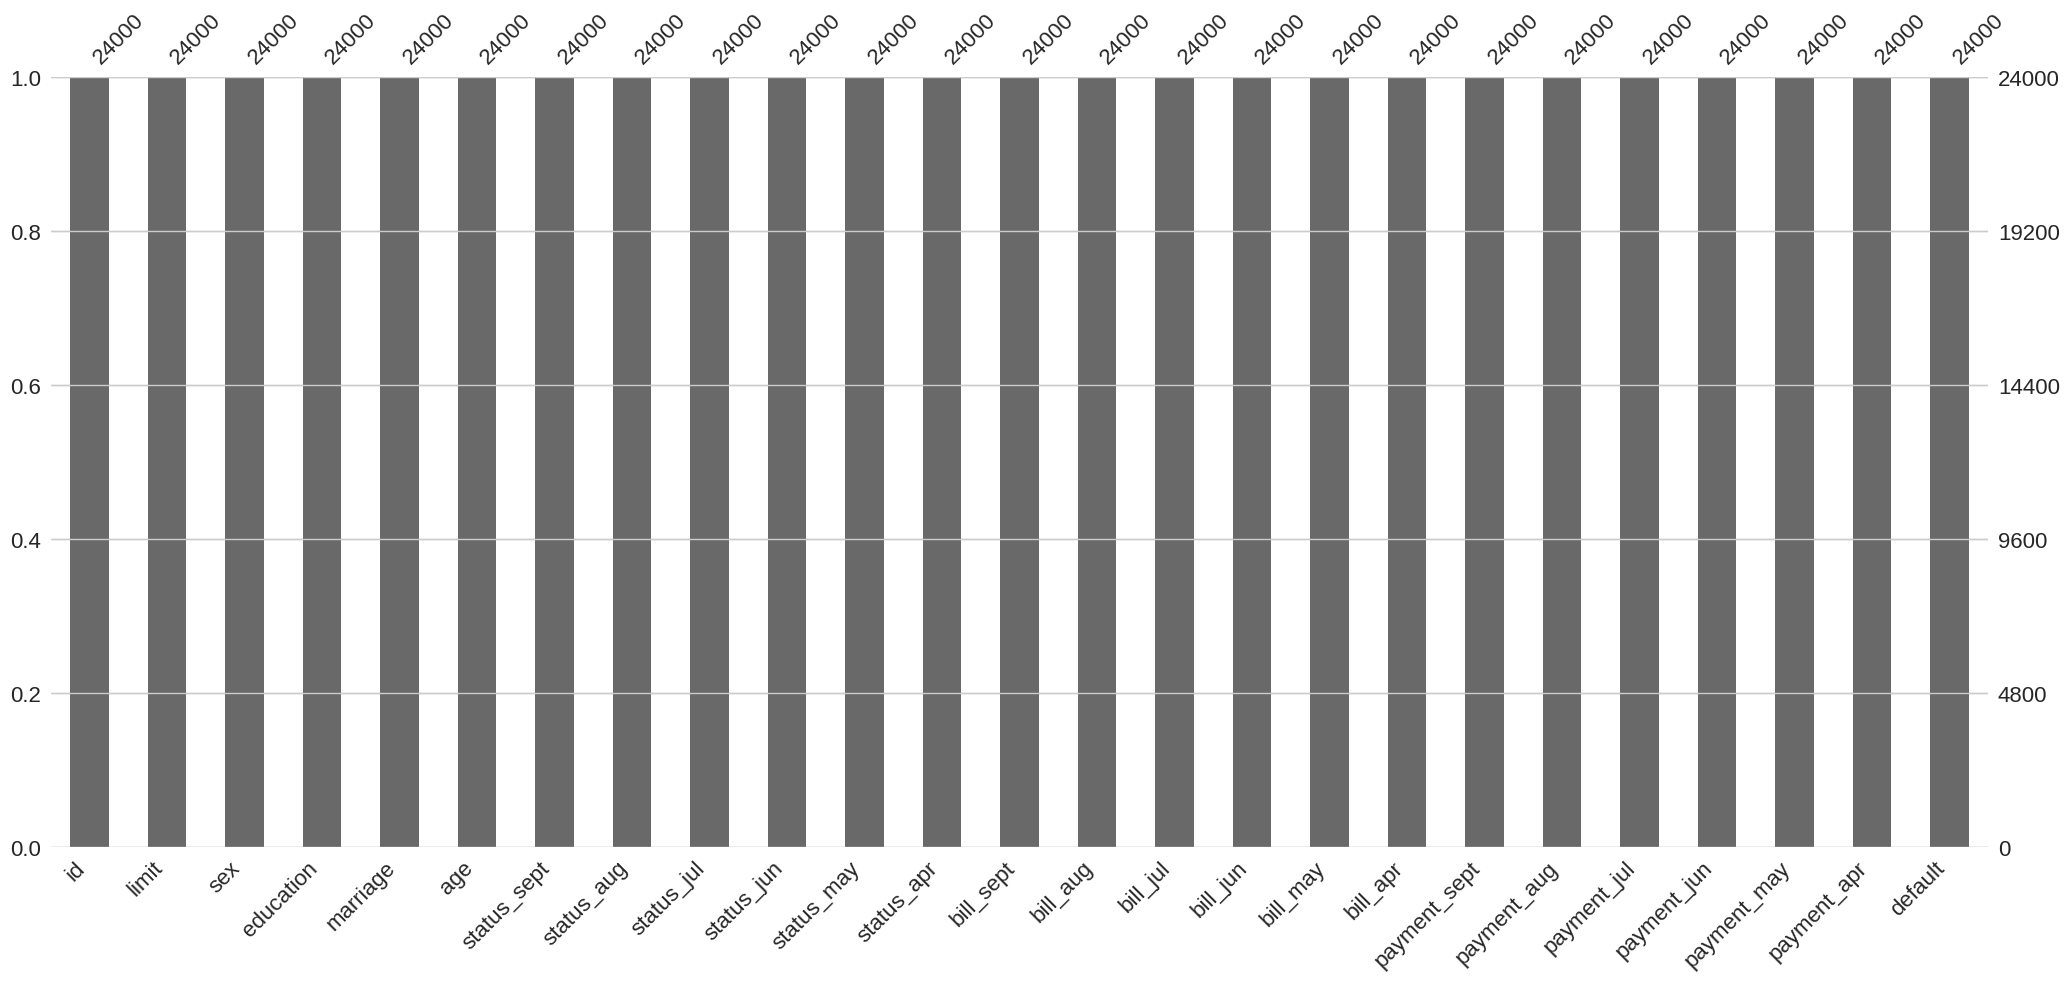

In [24]:
msno.bar(df_train_copy)
plt.show

#################### SEX ####################
Description:
count      24000
unique         2
top       Female
freq       14514
Name: sex, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
        Count  Frequency (%)
sex                         
Female  14514         60.475
Male     9486         39.525


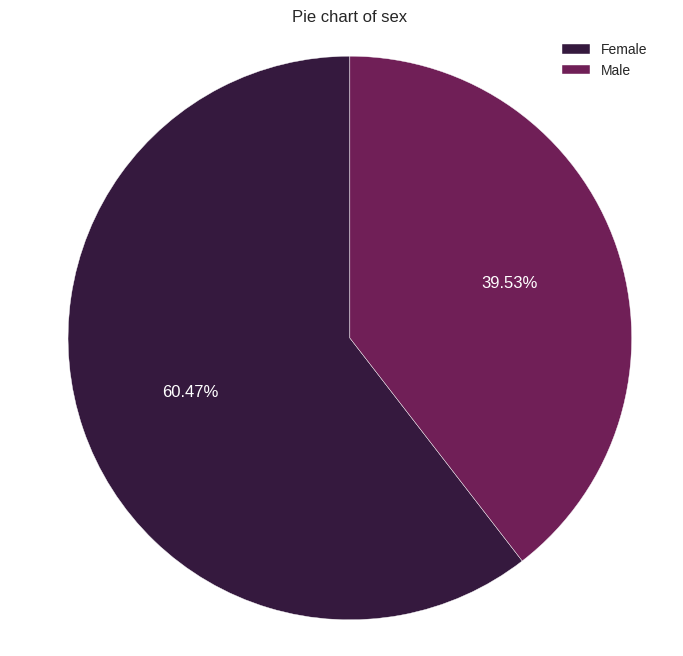

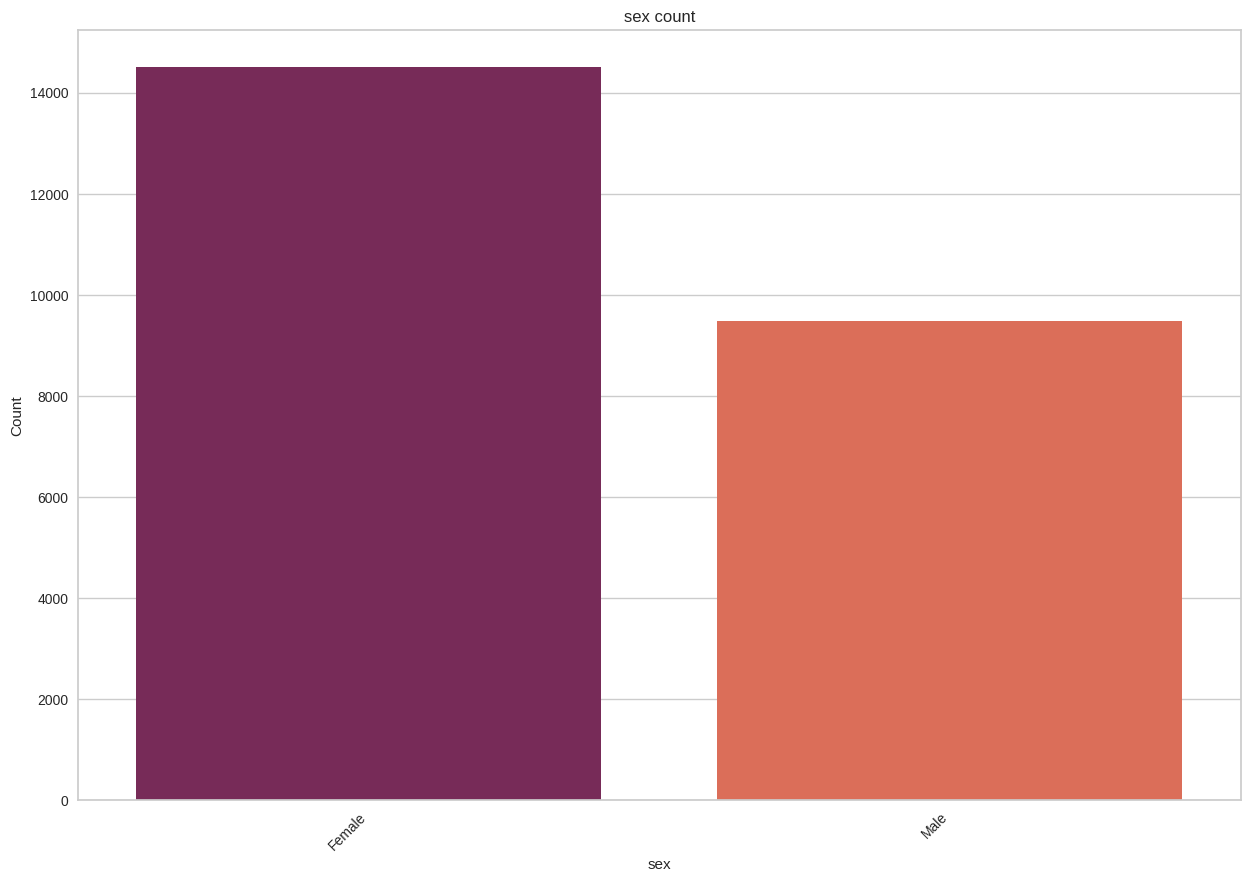

Crosstab for sex:
default         No        Yes
sex                          
Female   79.350971  20.649029
Male     75.627240  24.372760



#################### EDUCATION ####################
Description:
count          24000
unique             4
top       University
freq           11256
Name: education, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                 Count  Frequency (%)
education                            
University       11256      46.900000
Graduate school   8455      35.229167
High school       3903      16.262500
Other              386       1.608333


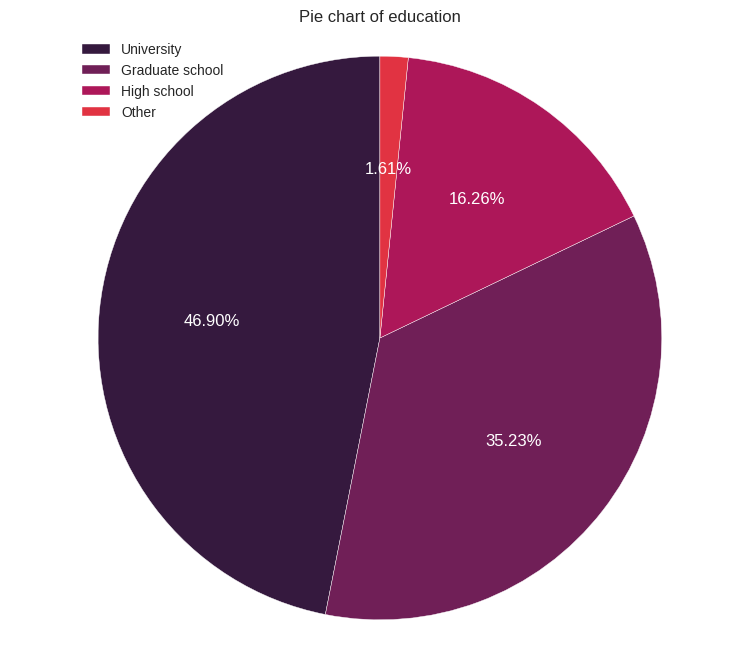

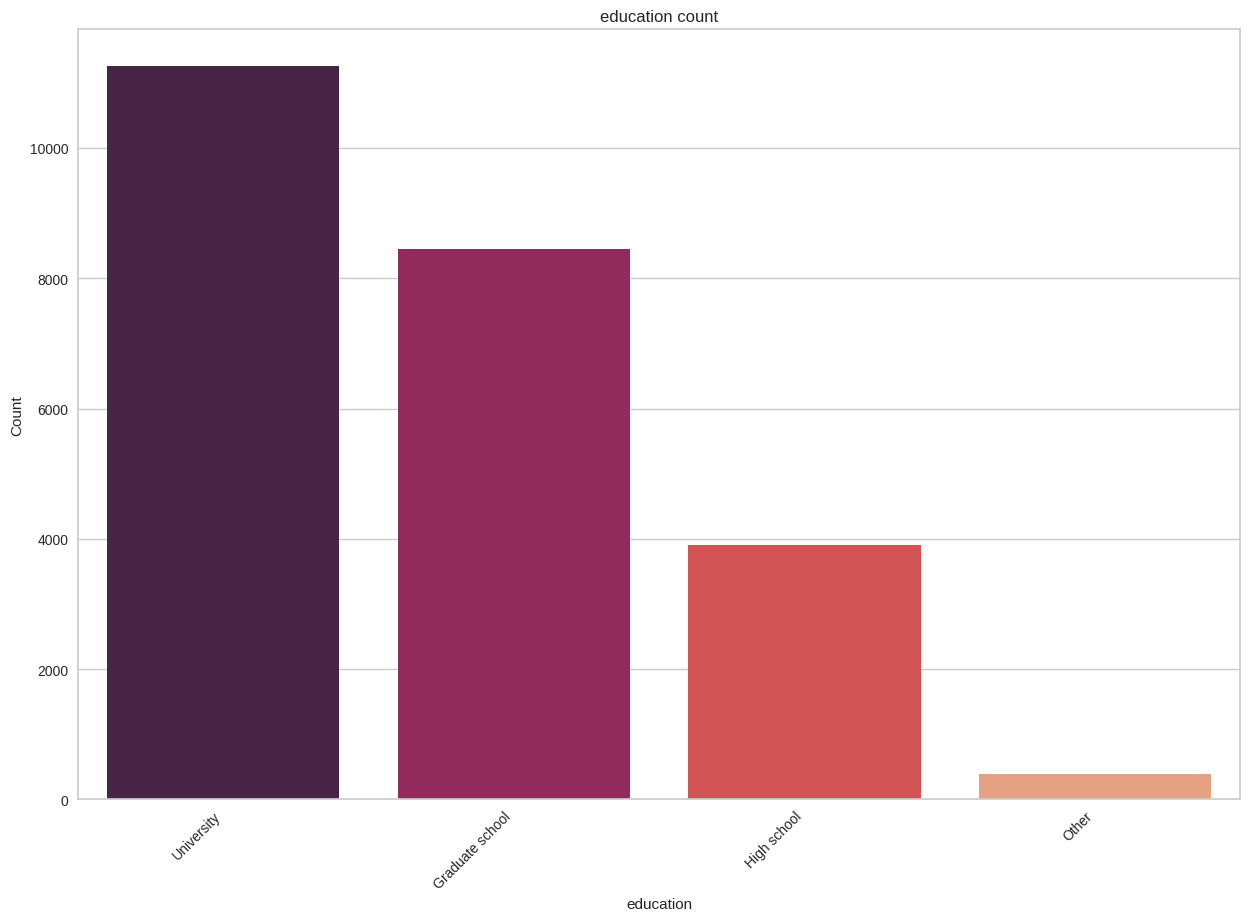

Crosstab for education:
default                 No        Yes
education                            
Graduate school  80.709639  19.290361
High school      74.993595  25.006405
Other            92.746114   7.253886
University       76.243781  23.756219



#################### MARRIAGE ####################
Description:
count      24000
unique         3
top       Single
freq       12806
Name: marriage, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
          Count  Frequency (%)
marriage                      
Single    12806      53.358333
Married   10892      45.383333
Other       302       1.258333


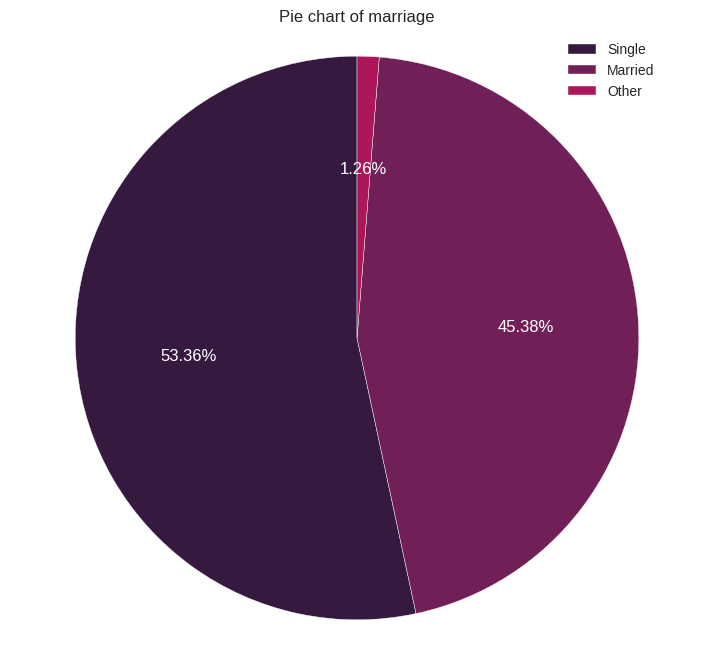

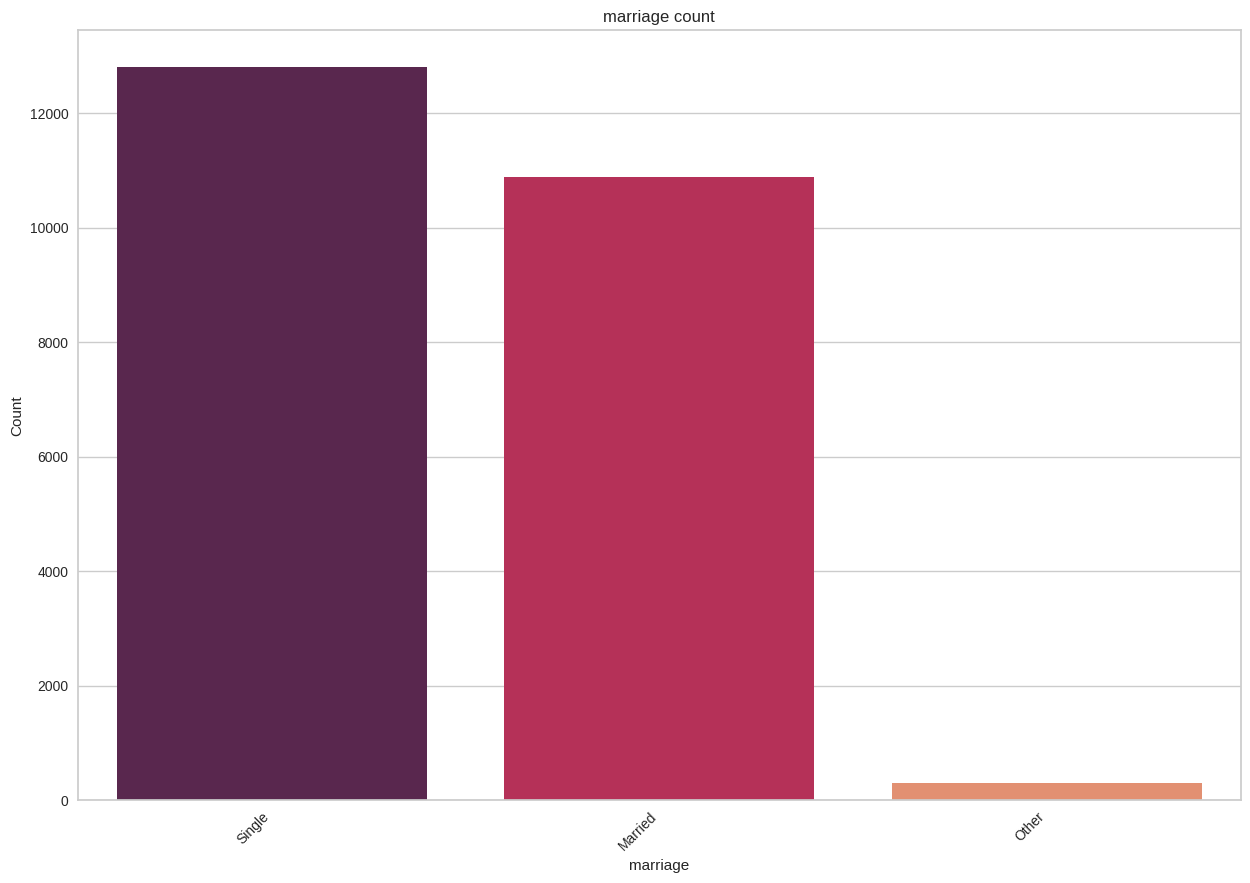

Crosstab for marriage:
default          No        Yes
marriage                      
Married   76.698494  23.301506
Other     74.503311  25.496689
Single    78.962986  21.037014



#################### STATUS_SEPT ####################
Description:
count                24000
unique                  11
top       Revolving credit
freq                 11781
Name: status_sept, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                  Count  Frequency (%)
status_sept                           
Revolving credit  11781      49.087500
Paid in full       4527      18.862500
1 month delay      3000      12.500000
No consumption     2198       9.158333
2 months delay     2138       8.908333
3 months delay      245       1.020833
4 months delay       58       0.241667
5 months delay       18       0.075000
8 months delay       16       0.066667
6 months delay       10       0.041667
7 months

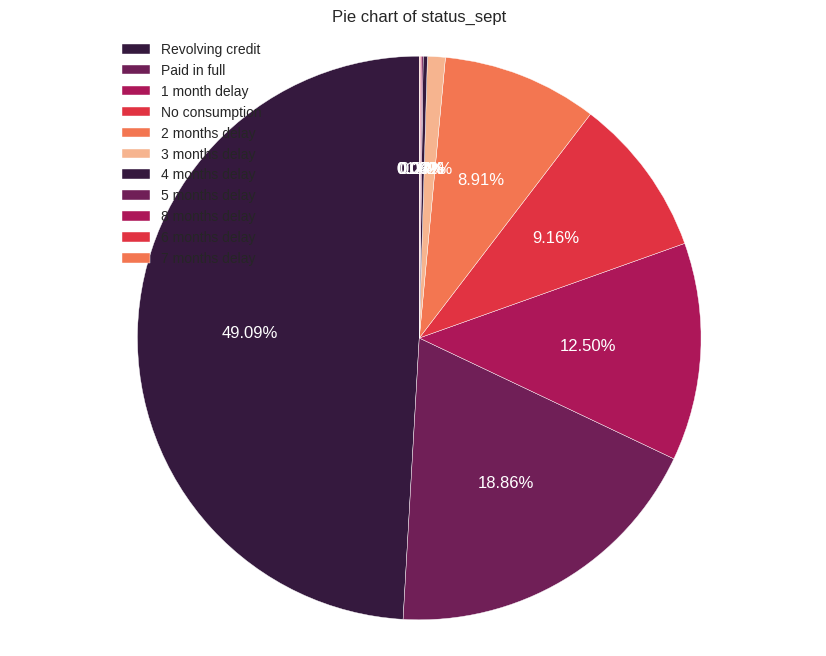

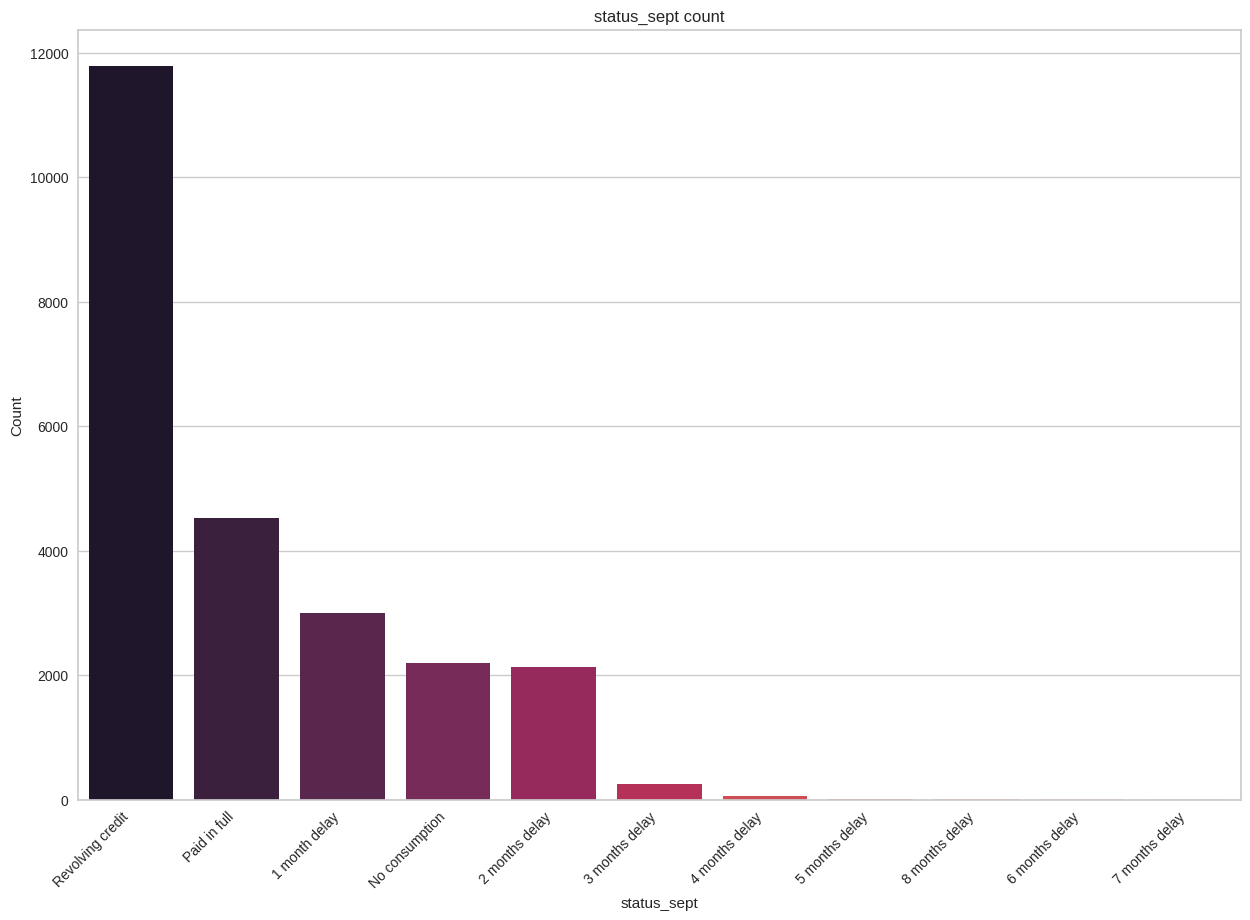

Crosstab for status_sept:
default                  No        Yes
status_sept                           
1 month delay     65.633333  34.366667
2 months delay    30.636109  69.363891
3 months delay    23.265306  76.734694
4 months delay    34.482759  65.517241
5 months delay    55.555556  44.444444
6 months delay    40.000000  60.000000
7 months delay    22.222222  77.777778
8 months delay    50.000000  50.000000
No consumption    87.306642  12.693358
Paid in full      83.366468  16.633532
Revolving credit  87.199728  12.800272



#################### STATUS_AUG ####################
Description:
count                24000
unique                  11
top       Revolving credit
freq                 12573
Name: status_aug, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                  Count  Frequency (%)
status_aug                            
Revolving credit  12573      52.387500
Paid i

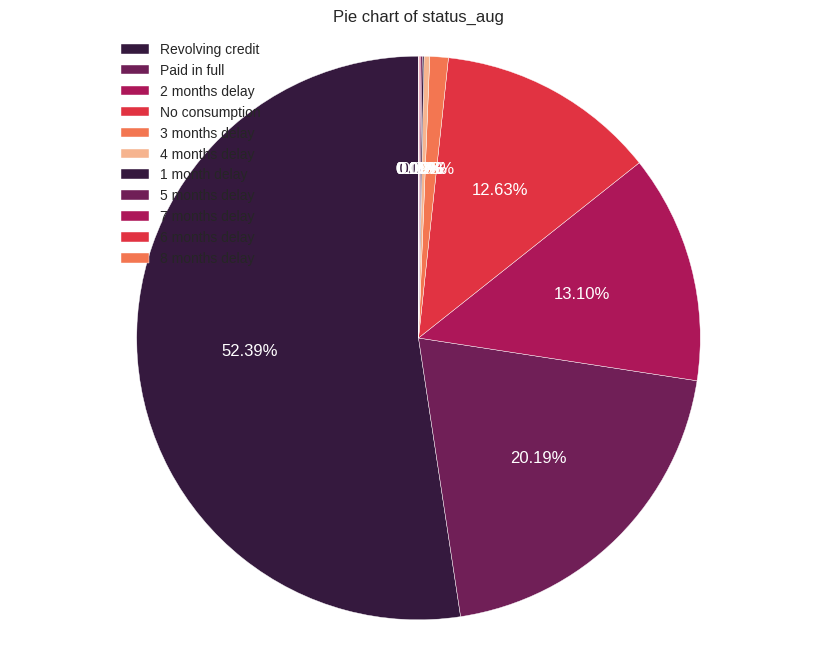

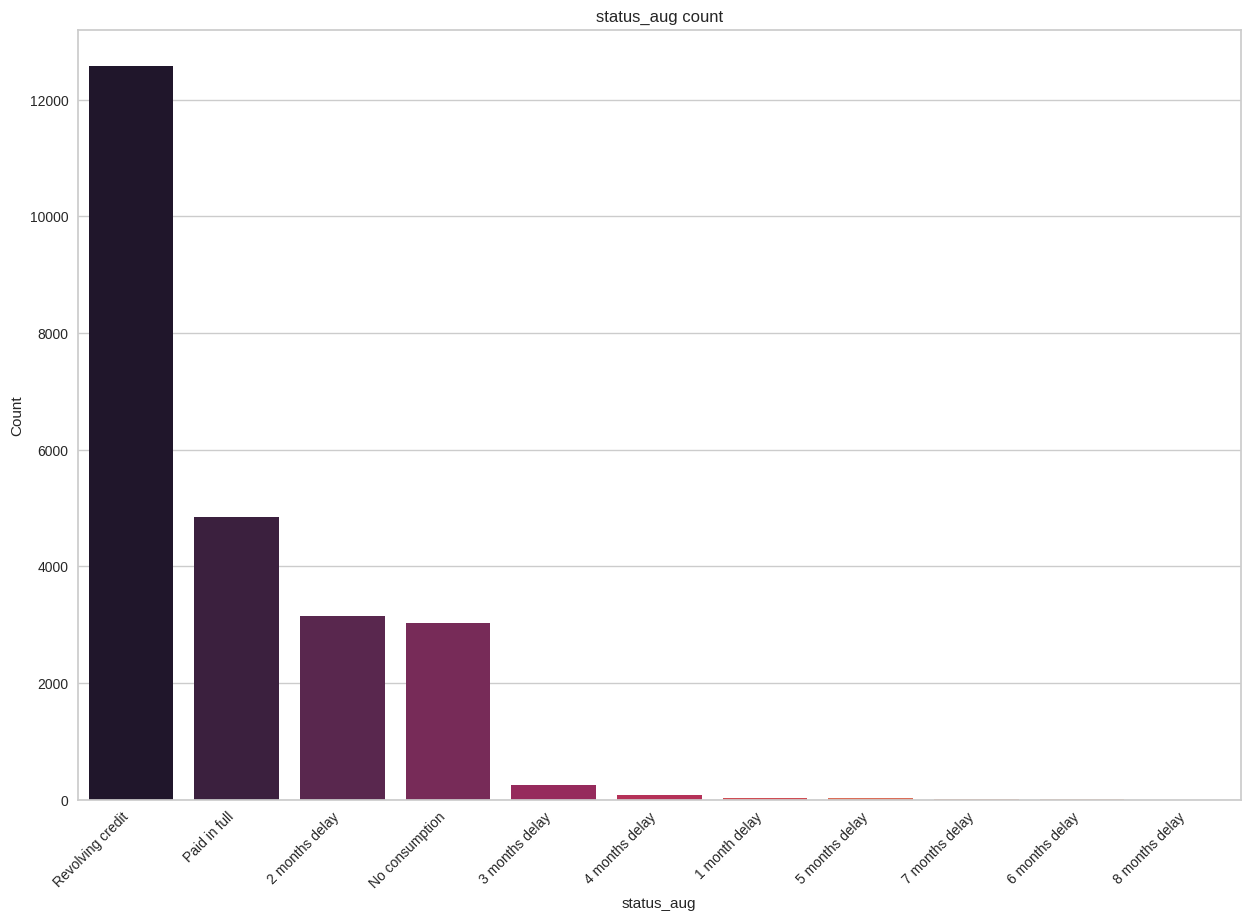

Crosstab for status_aug:
default                   No        Yes
status_aug                             
1 month delay      80.000000  20.000000
2 months delay     44.387917  55.612083
3 months delay     36.220472  63.779528
4 months delay     50.000000  50.000000
5 months delay     38.095238  61.904762
6 months delay     27.272727  72.727273
7 months delay     47.058824  52.941176
8 months delay    100.000000   0.000000
No consumption     82.046205  17.953795
Paid in full       84.024768  15.975232
Revolving credit   84.045176  15.954824



#################### STATUS_JUL ####################
Description:
count                24000
unique                  11
top       Revolving credit
freq                 12636
Name: status_jul, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                  Count  Frequency (%)
status_jul                            
Revolving credit  12636      52.6

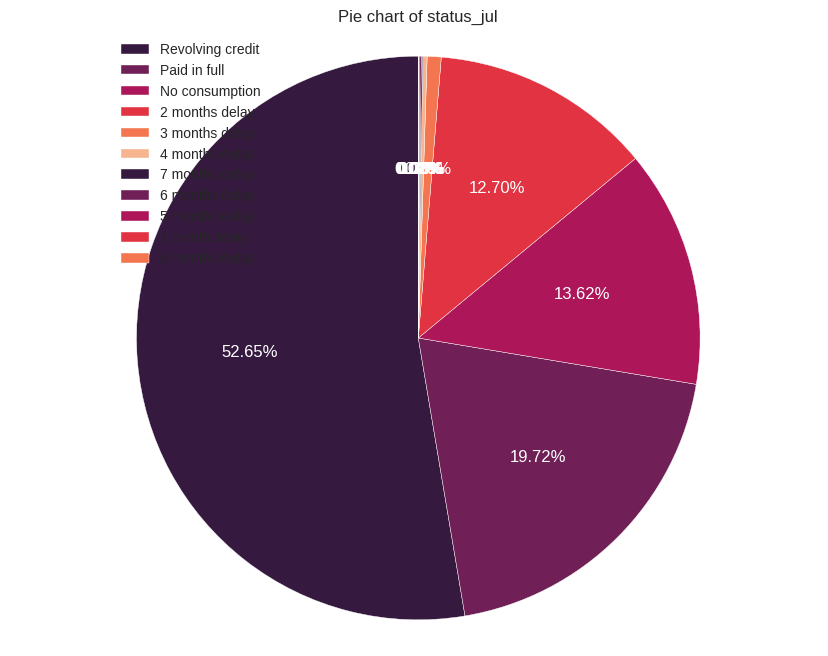

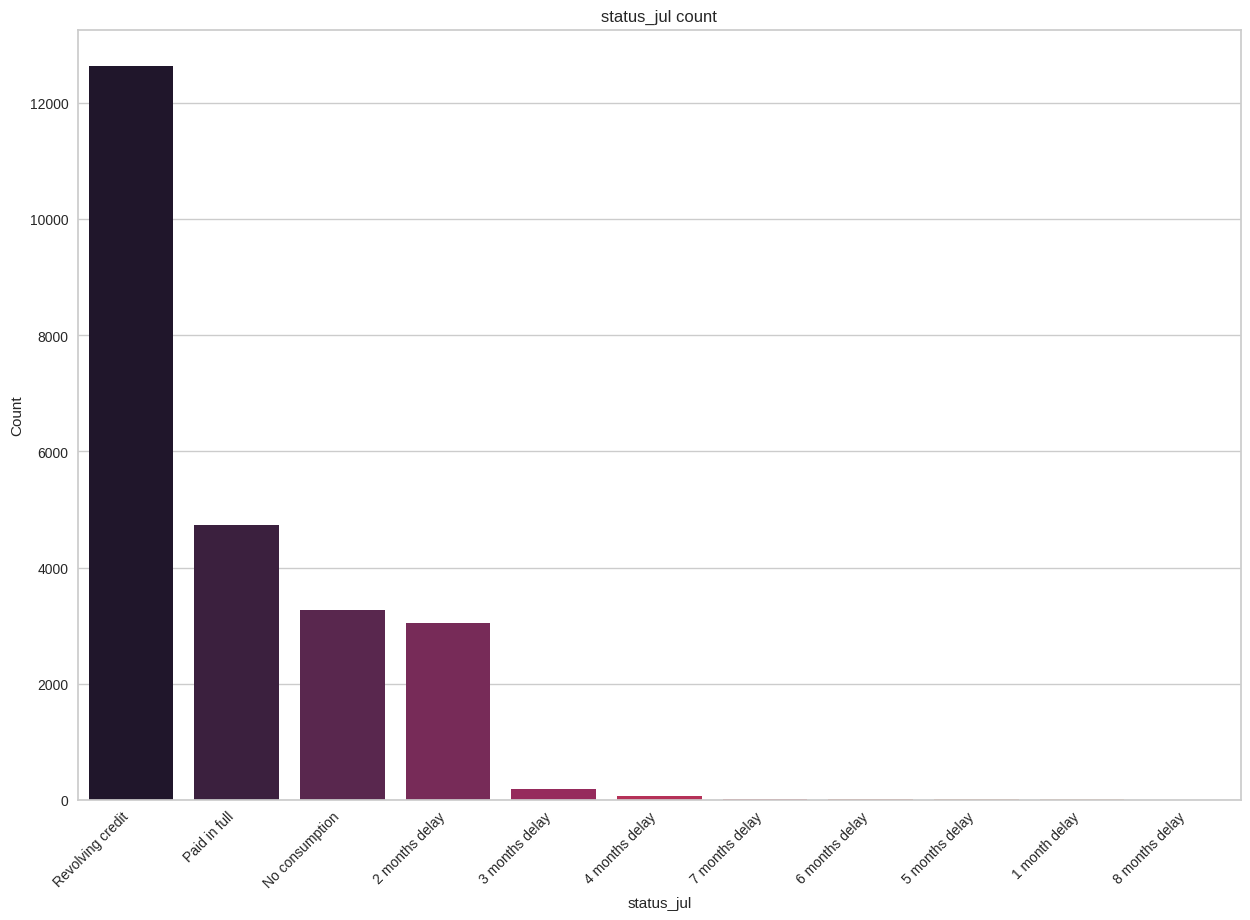

Crosstab for status_jul:
default                  No         Yes
status_jul                             
1 month delay     66.666667   33.333333
2 months delay    48.179731   51.820269
3 months delay    42.187500   57.812500
4 months delay    45.000000   55.000000
5 months delay    37.500000   62.500000
6 months delay    42.105263   57.894737
7 months delay    20.000000   80.000000
8 months delay     0.000000  100.000000
No consumption    81.987768   18.012232
Paid in full      84.449609   15.550391
Revolving credit  82.431149   17.568851



#################### STATUS_JUN ####################
Description:
count                24000
unique                  11
top       Revolving credit
freq                 13180
Name: status_jun, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                  Count  Frequency (%)
status_jun                            
Revolving credit  13180      54.9

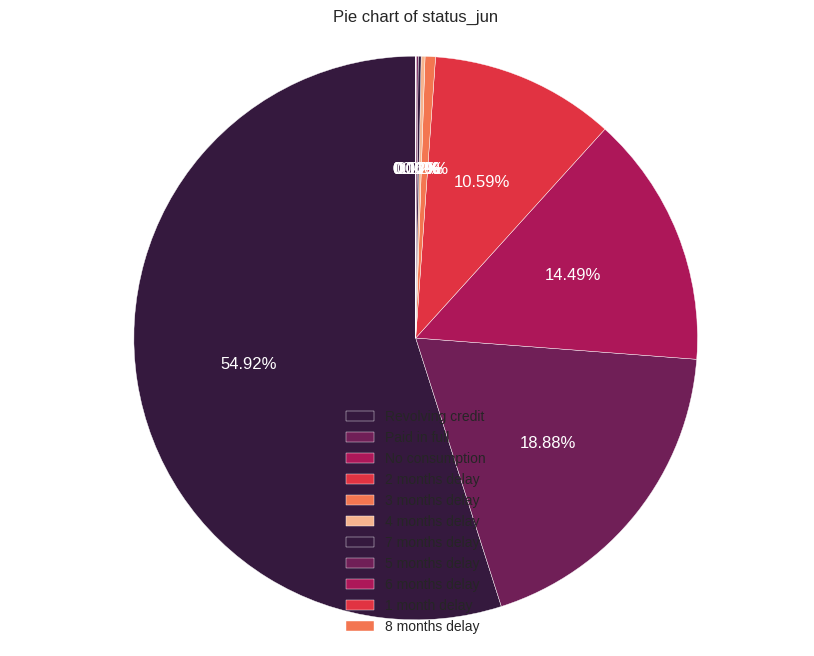

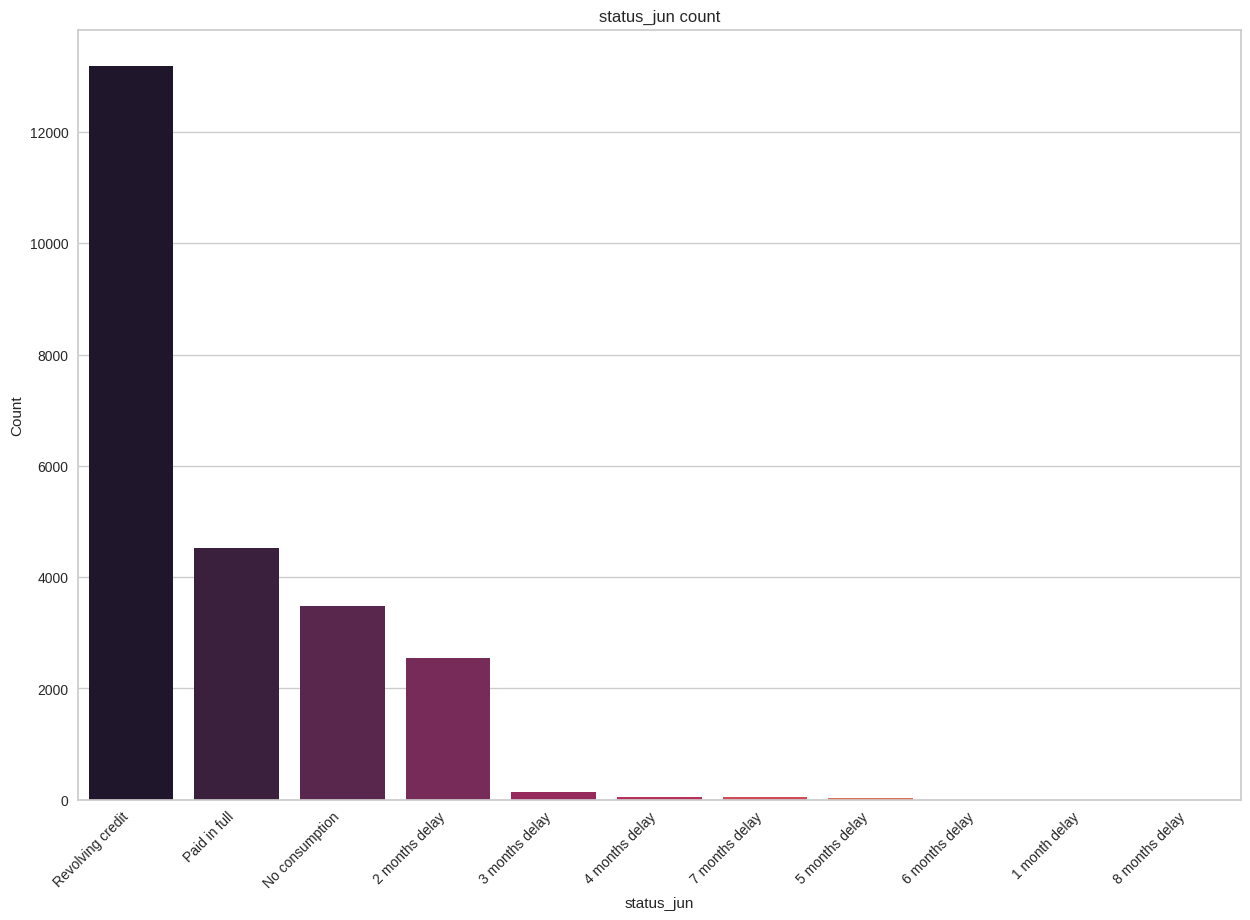

Crosstab for status_jun:
default                  No         Yes
status_jun                             
1 month delay     50.000000   50.000000
2 months delay    47.364280   52.635720
3 months delay    39.160839   60.839161
4 months delay    35.849057   64.150943
5 months delay    57.142857   42.857143
6 months delay    66.666667   33.333333
7 months delay    15.000000   85.000000
8 months delay     0.000000  100.000000
No consumption    81.420765   18.579235
Paid in full      84.065328   15.934672
Revolving credit  81.540212   18.459788



#################### STATUS_MAY ####################
Description:
count                24000
unique                  10
top       Revolving credit
freq                 13560
Name: status_may, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                  Count  Frequency (%)
status_may                            
Revolving credit  13560      56.5

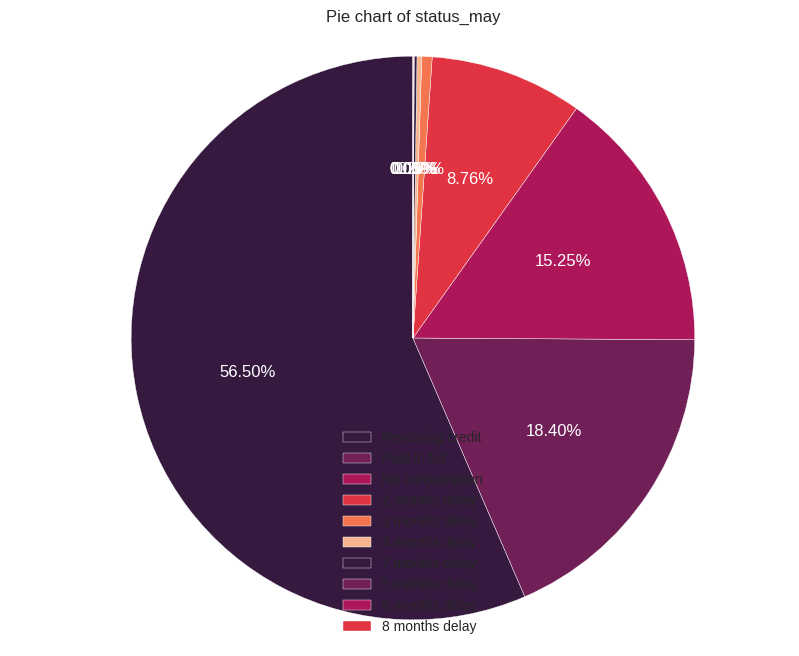

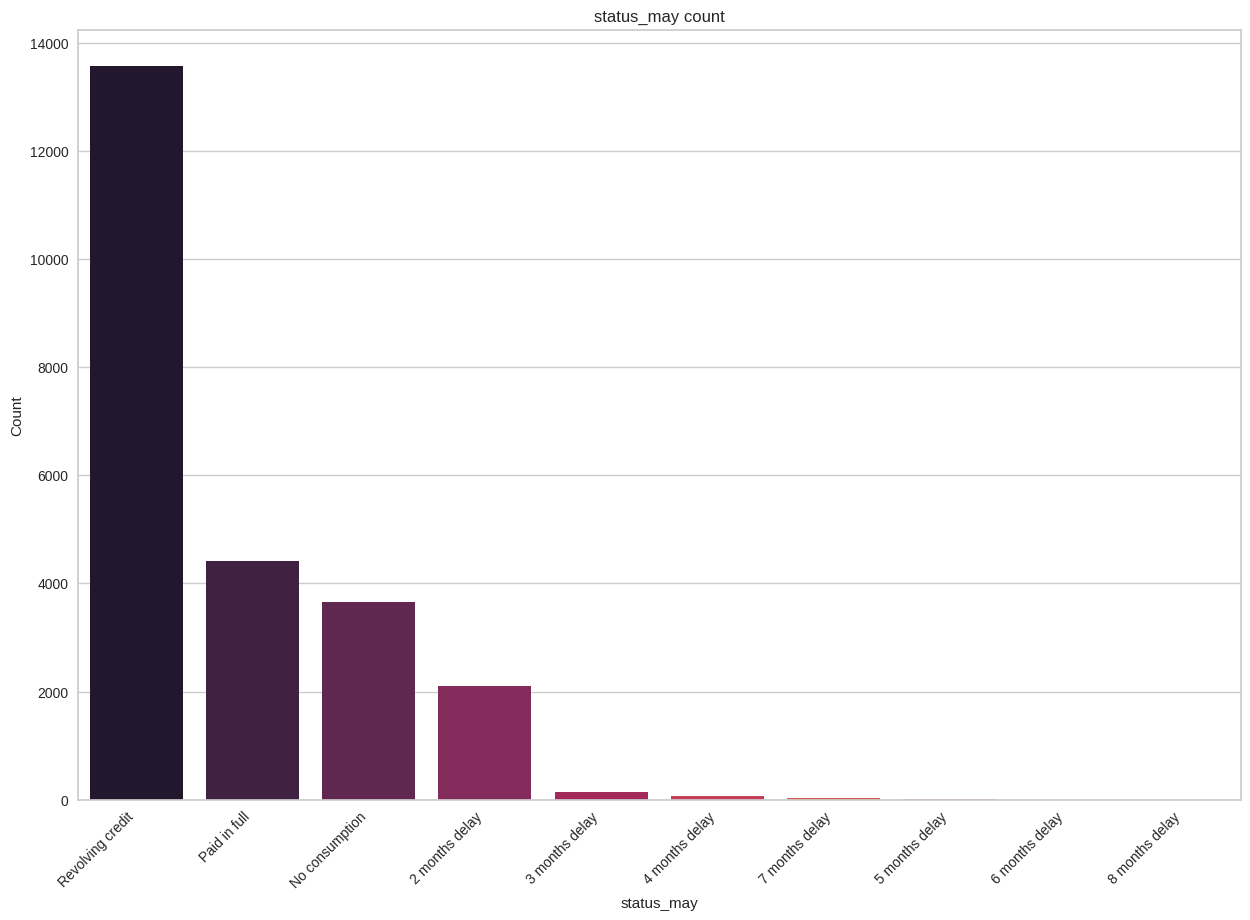

Crosstab for status_may:
default                  No         Yes
status_may                             
2 months delay    45.385347   54.614653
3 months delay    40.845070   59.154930
4 months delay    43.076923   56.923077
5 months delay    46.153846   53.846154
6 months delay     0.000000  100.000000
7 months delay    15.789474   84.210526
8 months delay     0.000000  100.000000
No consumption    80.841760   19.158240
Paid in full      83.337107   16.662893
Revolving credit  81.120944   18.879056



#################### STATUS_APR ####################
Description:
count                24000
unique                  10
top       Revolving credit
freq                 13008
Name: status_apr, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                  Count  Frequency (%)
status_apr                            
Revolving credit  13008      54.200000
Paid in full       4576      19.06

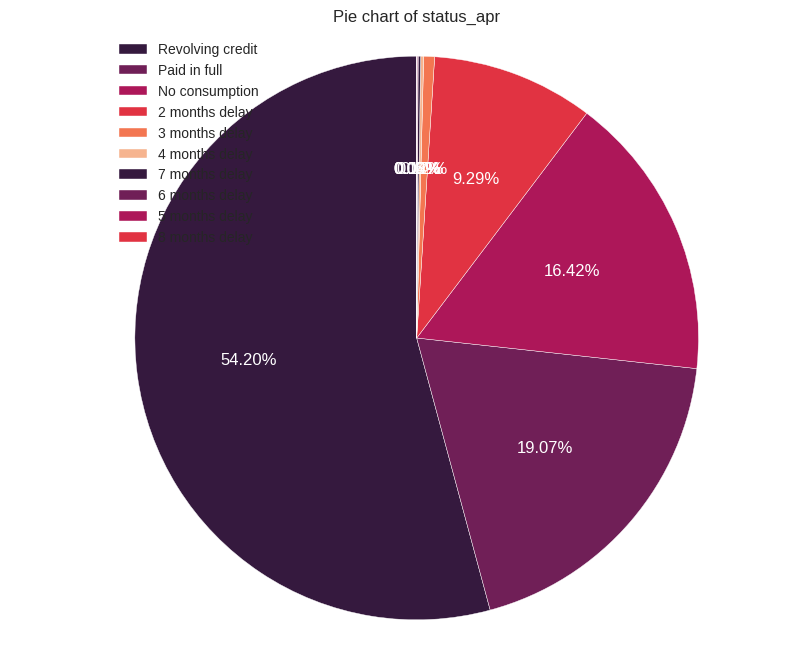

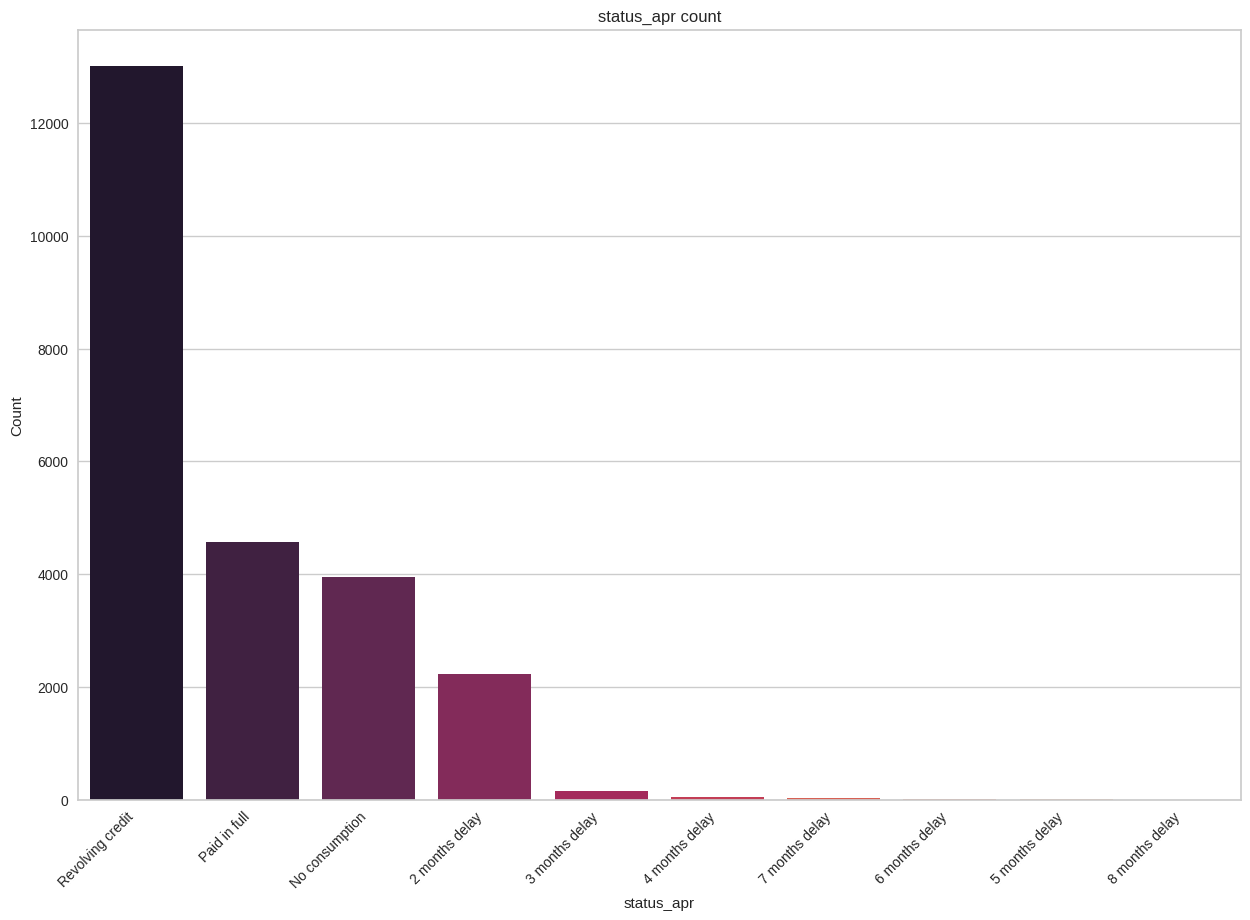

Crosstab for status_apr:
default                  No         Yes
status_apr                             
2 months delay    49.327354   50.672646
3 months delay    37.583893   62.416107
4 months delay    30.952381   69.047619
5 months delay    37.500000   62.500000
6 months delay    27.272727   72.727273
7 months delay    18.181818   81.818182
8 months delay     0.000000  100.000000
No consumption    80.263825   19.736175
Paid in full      83.107517   16.892483
Revolving credit  81.050123   18.949877



#################### DEFAULT ####################
Description:
count     24000
unique        2
top          No
freq      18691
Name: default, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
         Count  Frequency (%)
default                      
No       18691      77.879167
Yes       5309      22.120833


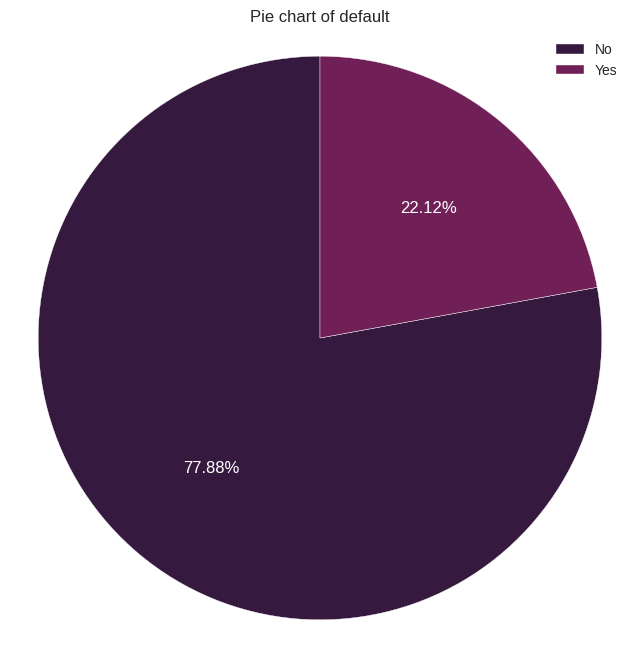

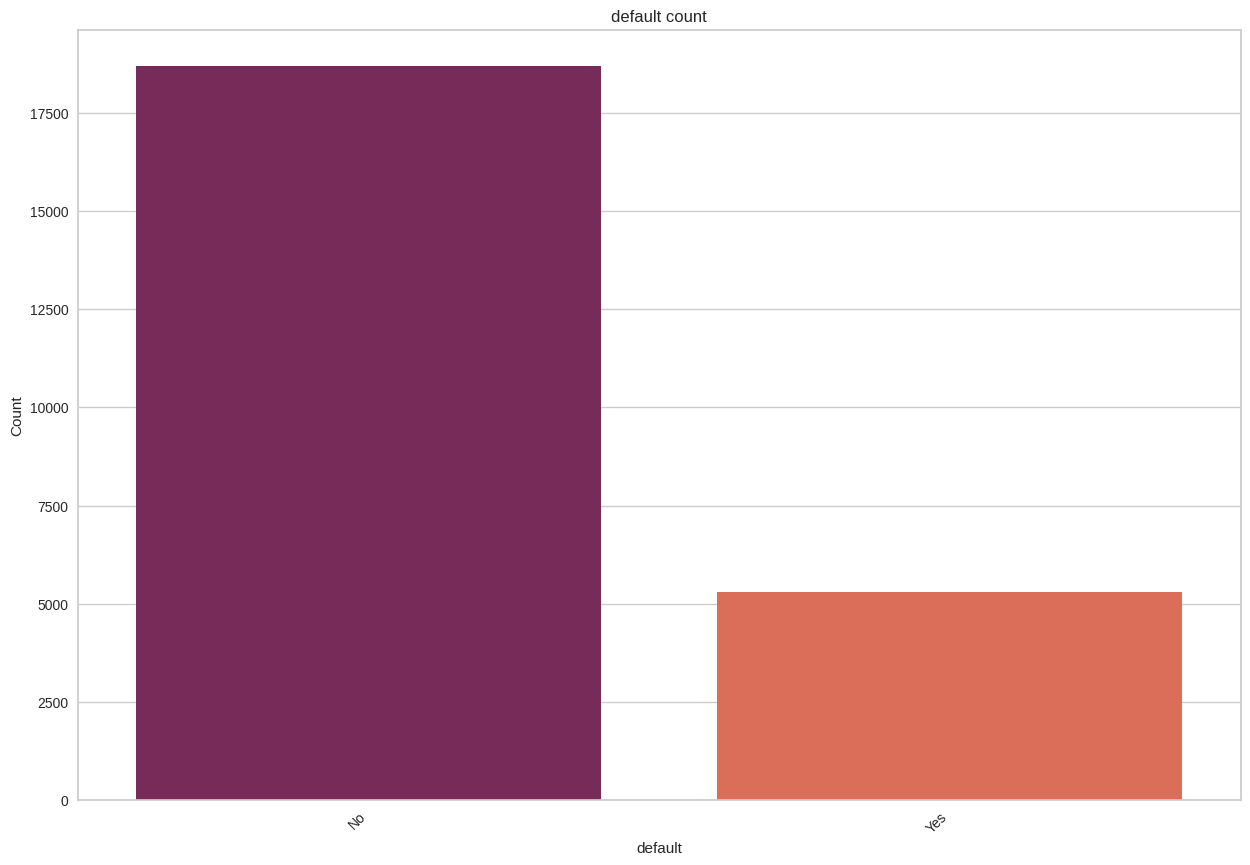

Crosstab for default:
default     No    Yes
default              
No       100.0    0.0
Yes        0.0  100.0





In [25]:
# Univariate analysis of important variables followed by some conclusions for each/all on training set

num_cols = df_train_copy.select_dtypes(['int64', 'float64']).columns
num_cols = num_cols[num_cols != 'id']
cat_cols = df_train_copy.select_dtypes(['object']).columns

def num_pipeline_apply(feature):
    print(f"{'#' * 20} {feature.upper()} {'#' * 20}")
    gen_info_feat(df_train_copy, feature)
    create_bar_plot(df_train_copy, feature)
    create_box_plot(df_train_copy, feature)
    create_hist_plot(df_train_copy, feature)
    default_box_plot(df_train_copy, feature)
    print("\n")

def cat_pipeline_apply(feature):
    print(f"{'#' * 20} {feature.upper()} {'#' * 20}")
    gen_info_feat(df_train_copy, feature)
    create_pie_plot(df_train_copy, feature)
    create_bar_plot(df_train_copy, feature)
    crosstab = pd.crosstab(df_train_copy[feature], df_train_copy['default'])
    crosstab_norm = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
    print(f"Crosstab for {feature}:\n{crosstab_norm}\n")
    print("\n")

for feature in num_cols:
    num_pipeline_apply(feature)

for feature in cat_cols:
    cat_pipeline_apply(feature)

Findings:
- Limit – as shown by both histogram and the boxplot, the right skewed distribution suggests an uneven distribution of credit limits and a presence of outliers in the upper areas of the limit, as most of the individuals have lower credit limits (below 500,000 TWD). The boxplot of limit values grouped by default categories suggests that people who default tend to be characterised by a lower median credit limit, with IQR between 10,000 and 190,000 TWD. That can be due to the fact that they would be perceived as higher risk individuals by the lender, as well as assumed lower income.

- Age – as suggested by both histogram and boxplot, the distribution of the age variable is once again right-skewed, suggesting that older people make up for the outliers of credit card holders, as people over the age of 60 are outside the boxplot range. That could be due to retirement, reduced income or shifting financial behaviours (e.g. using savings rather than a credit card). Despite there being no differences in the median age for people based on whether they have defaulted or not, people who defaulted tend to be characterised by slightly older age – with boxplot values ranging between 21 and 63, rather than 21 and 60. The findings could suggest a need for credit products tailored to the needs of older individuals (e.g. lower-interest plans, flexible payment options) and potentially a separate assessment model for them.

- Sex – despite women making up for the majority (60.47%, over 14,000 counts) of the credit card members, they tend to default at lower rates than men (20.64% of women defaulted compared to 24.37% of men). This can be due to the fact that acting as the ‘captains of households’ (Ciciolla and Luthar, 2019), women are twice as likely as men to do the bulk of family budgeting, suggesting greater financial participation and responsibilities (Parker, 2020). The fact that men tend to default more could be caused not only by the way in which men are socialised – they tend to spend more on entertainment and eating out, but also by the gender pay gap, as women tend to be more conservative with their spending, having to budget smaller salaries (McGurran, 2020).

- Education – the majority of the card members have a degree, as 46.9% have finished university, 35.23% have finished graduate school and 16.26% have completed high school. Individuals who have completed high school only tend to default at greater rates (25%) than those of higher education (university – 23.75%, and graduate school – 19.29%). Obtaining higher education might lead not only to securing higher paying, more stable jobs, but also could make the individuals more aware of budgeting, debt handling and investment strategies which would aid them managing their funds.

- Marriage – at 53.36%, the majority of the card holders are single, while 45.38% are married. Despite the difference not being significant, it is the married individuals that tend to default more, at 23.3% compared to the 21.03% for singles. That could suggest that marriage may be a risk factor for default, possibly due to financial obligations, joint spending, family responsibilities, and shared debts. Credit card companies could use this insight to refine risk management strategies by offering targeted financial counselling, as well as developing offers that would appeal to married individuals experiencing financial strain (e.g. lower interest rates, flexible repayment plans).


In [26]:
#Bivariate analysis
#1. Numerical - numerical features (scatterplots and correlation)

In [27]:
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24000 entries, 22788 to 27126
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            24000 non-null  int64  
 1   limit         24000 non-null  float64
 2   sex           24000 non-null  object 
 3   education     24000 non-null  object 
 4   marriage      24000 non-null  object 
 5   age           24000 non-null  int64  
 6   status_sept   24000 non-null  object 
 7   status_aug    24000 non-null  object 
 8   status_jul    24000 non-null  object 
 9   status_jun    24000 non-null  object 
 10  status_may    24000 non-null  object 
 11  status_apr    24000 non-null  object 
 12  bill_sept     24000 non-null  float64
 13  bill_aug      24000 non-null  float64
 14  bill_jul      24000 non-null  float64
 15  bill_jun      24000 non-null  float64
 16  bill_may      24000 non-null  float64
 17  bill_apr      24000 non-null  float64
 18  payment_sept  24000 non-nul

To explore the relationship between numerous variables the following methods were used:
- Scatterplots – as they provide a tool for an intuitive data analysis (McKinney, 2013),
that allow for visualisation of the relationships between both numerical and categorical variables, as well as discovering any potential correlation patterns in the data (Baesens et al., 2016).
- Boxplots, bar charts, and histograms.

As multicollinearity - where one of the predictor variable could be linearly predicted from the other - could lead to poor model performance, it is desirable to detect inter-relationships between the explanatory variables before the process of modelling starts. According to the Figures 14 and 15, which visualise and compute the Pearson correlation coefficient between numeric variables, there is a high correlation between certain variables (r > 0.8) . That can be dealt with during dimensionality reduction further on in the process.

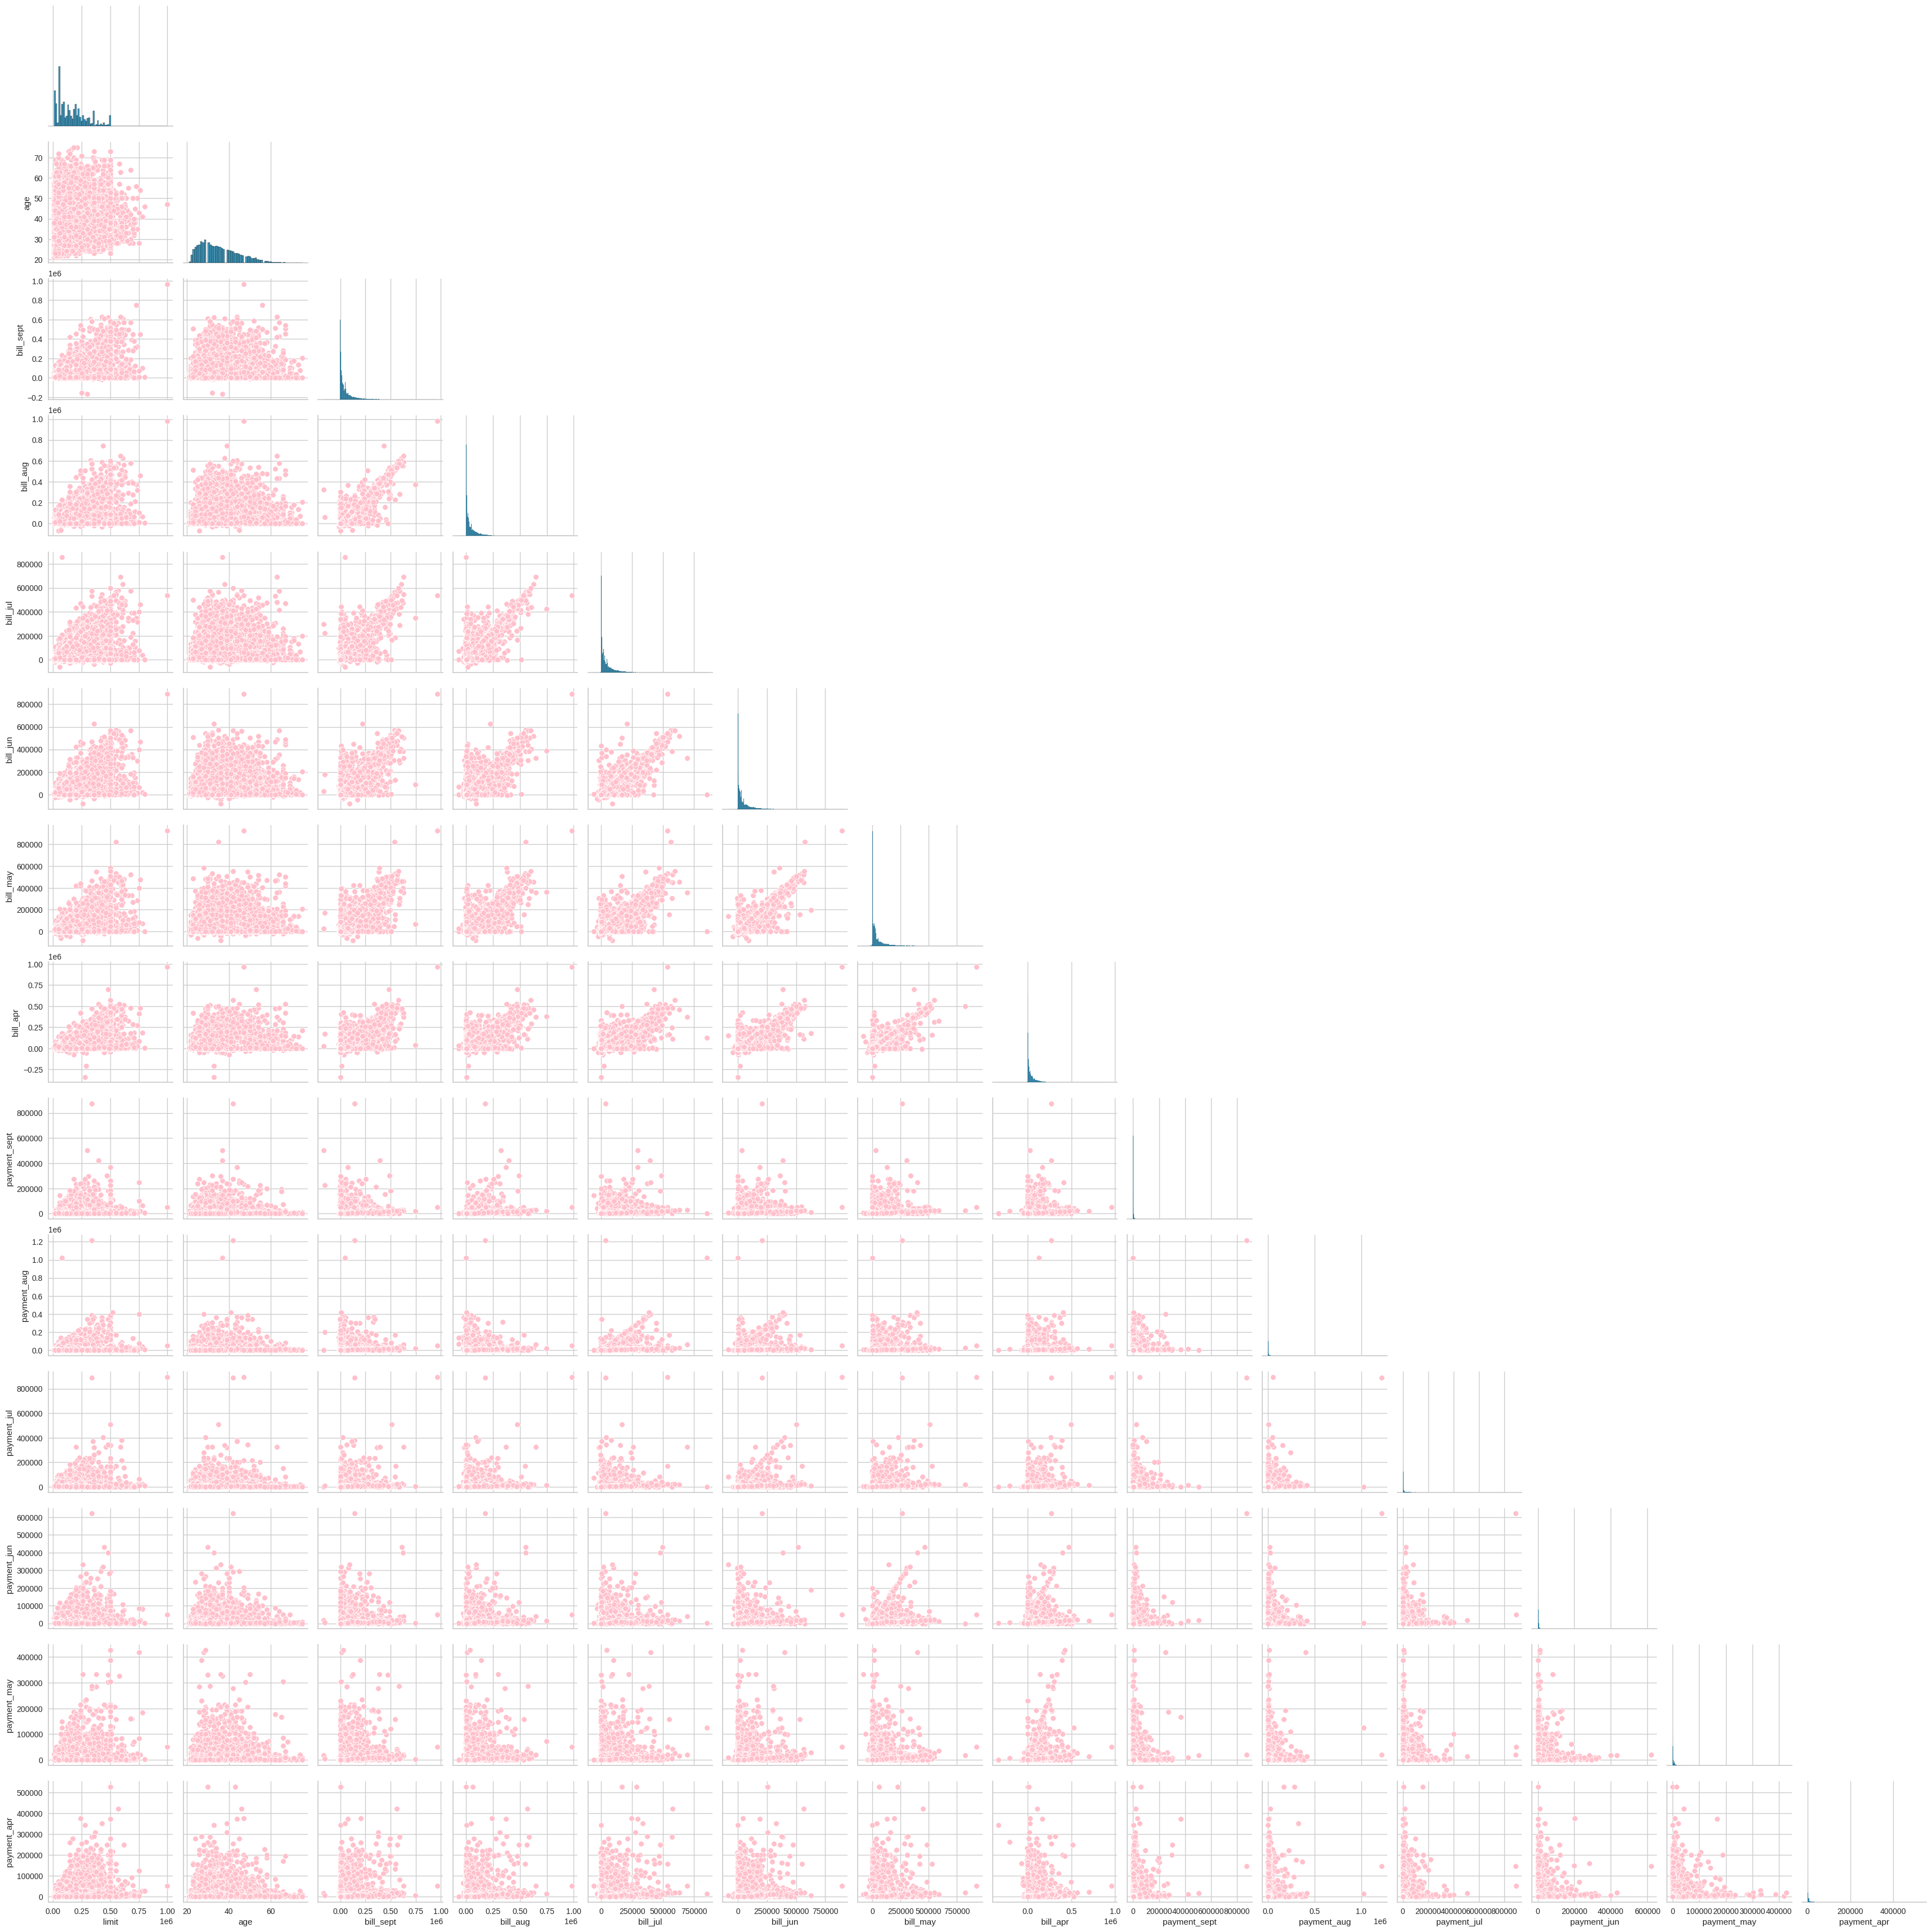

In [28]:
#Scatterplots

sns.pairplot(df_train_copy.drop(['id','sex', 'education', 'marriage', 'status_sept','status_aug', 'status_jul', 'status_jun', 'status_may', 'status_apr', 'default'],axis=1), corner=True, plot_kws={'color': 'pink'})  # Add plot_kws to set the color
plt.show()

In [ ]:
#To explore possible correlation and multicollinearity (features highly correlated a problem - >0.8, might have to drop one if two highly correlated) correlation analysis

#Correlation analysis with heatmap, after dropping the has a mobile phone with the target feature as int
df_train_copy['default_numeric'] = df_train_copy['default'].map({'No': 0, 'Yes': 1})
cc_train_copy_corr = pd.concat([df_train_copy.drop(['id','sex', 'education', 'marriage', 'status_sept','status_aug', 'status_jul', 'status_jun', 'status_may', 'status_apr', 'default'], axis=1),df_train_copy['default_numeric']],axis=1).corr() # Use the numeric version
mask = np.zeros_like(cc_train_copy_corr, dtype='bool')
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(18,10))
sns.heatmap(cc_train_copy_corr, annot=True, cmap='rocket',mask=mask, linewidths=.5)
plt.show()

df_train_copy.drop(columns=['default_numeric'], inplace=True)

#No values correlated strongly with TV, negative correlation with most of the features

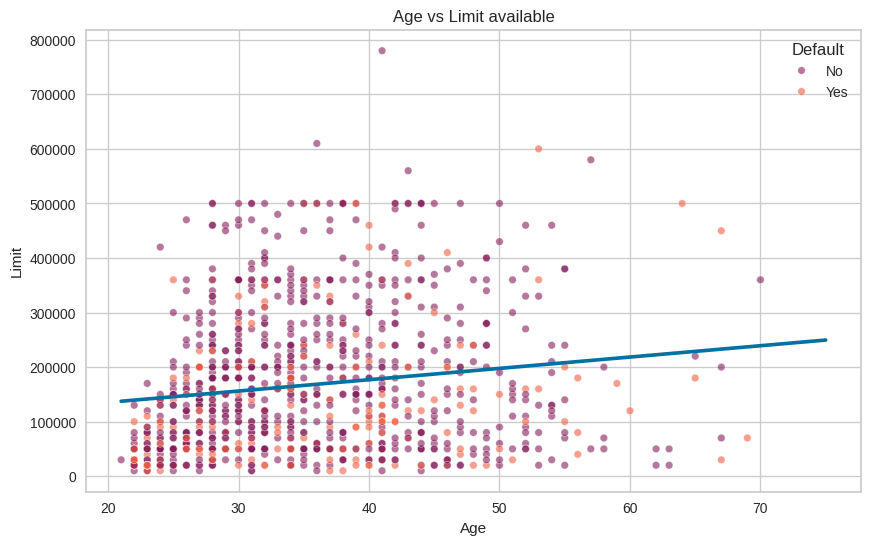

In [30]:
#As a lot of data - sample randomly to visualise the relationship between age and limit
fig = plt.figure(figsize=(10, 6))

sample_size = 1000
df_train_copy_sample = df_train_copy.sample(n=sample_size, random_state=42)

sns.regplot(x='age', y='limit', data=df_train_copy, ci=None, scatter=False)
sns.scatterplot(x='age', y='limit', data=df_train_copy_sample, color='red',
                hue='default', alpha=0.6, palette='rocket', s=30)

plt.title('Age vs Limit available')
plt.xlabel('Age')
plt.ylabel('Limit')
plt.legend(title='Default')
plt.show()


A scatterplot of the relationship between the age and limit, grouped by the default status suggests that credit card limit increases with age. Despite a higher amount of limit available, it is those over the age of 45 that default more (25.22%) compared to those who are 45 or under (21.55%). This counterintuitive result could be due to the fact that older individuals have had a longer time to build a reliable credit history, but also may face different financial pressures, including medical expenses or caring for dependents. The findings suggest that the credit limit may not be the best indicator of financial responsibility or low risk of default.

In [31]:
#Percentage of people over 45 who defaulted
over_45 = df_train_copy[df_train_copy['age'] > 45]
total_over_45 = len(over_45)
defaults_over_45 = len(over_45[over_45['default'] == 'Yes'])
percentage_defaults = (defaults_over_45 / total_over_45) * 100
print(f"Percentage of people over 45 who defaulted: {percentage_defaults:.2f}%")


Percentage of people over 45 who defaulted: 25.22%


In [32]:
#Percentage of people with age qual to or under 45 that defaulted
under_45 = df_train_copy[df_train_copy['age'] <= 45]
total_under_45 = len(under_45)
defaults_under_45 = len(under_45[under_45['default'] == 'Yes'])
percentage_defaults_under_45 = (defaults_under_45 / total_under_45) * 100
print(f"Percentage of people 45 or under who defaulted: {percentage_defaults_under_45:.2f}%")

Percentage of people 45 or under who defaulted: 21.55%


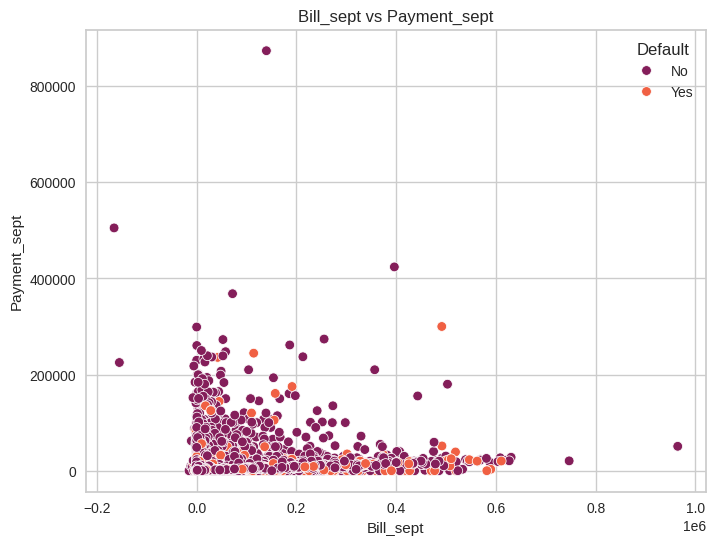

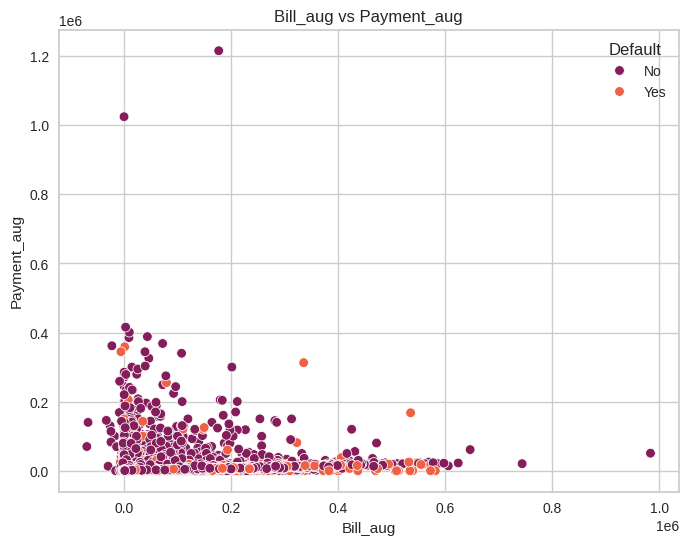

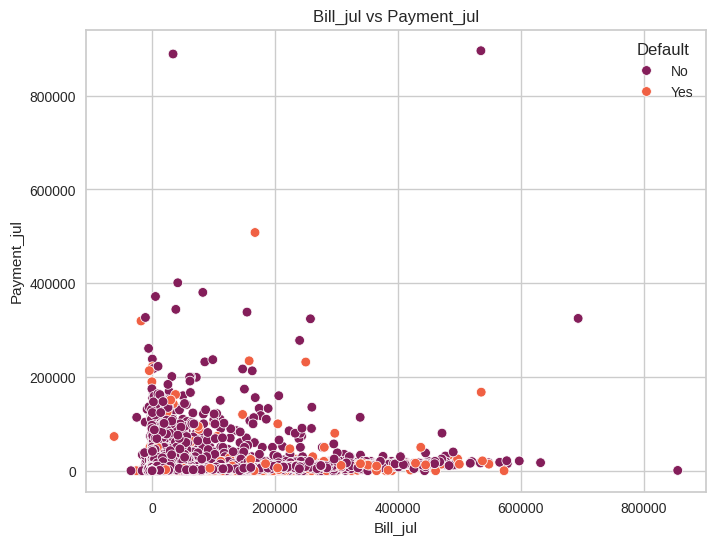

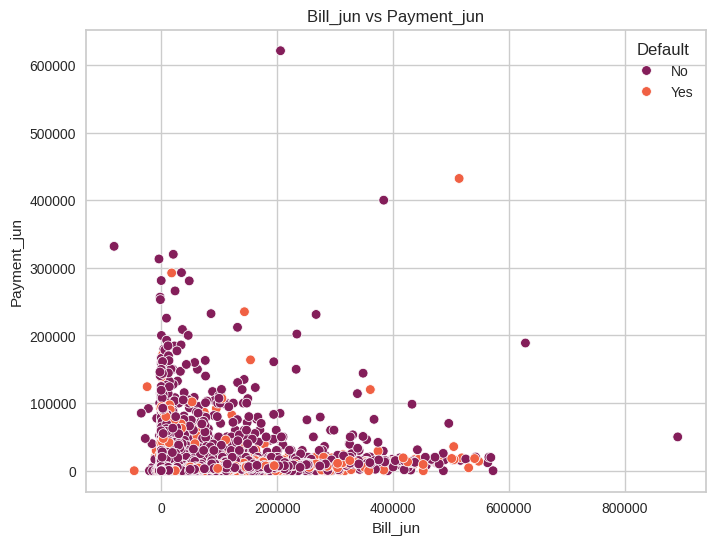

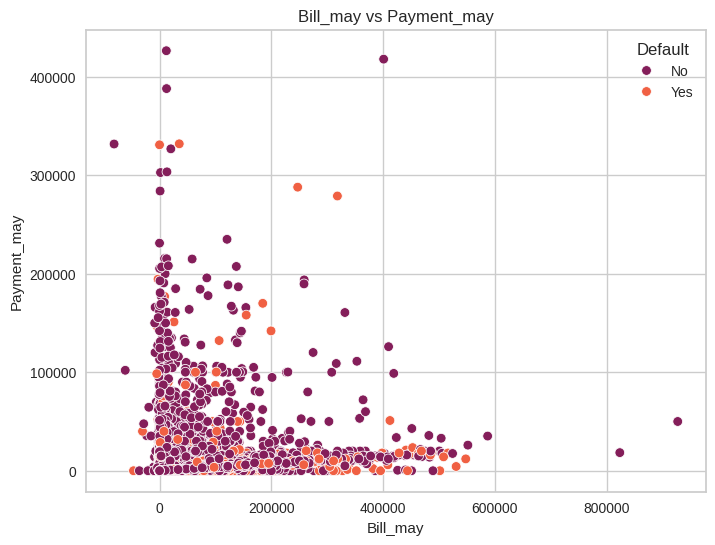

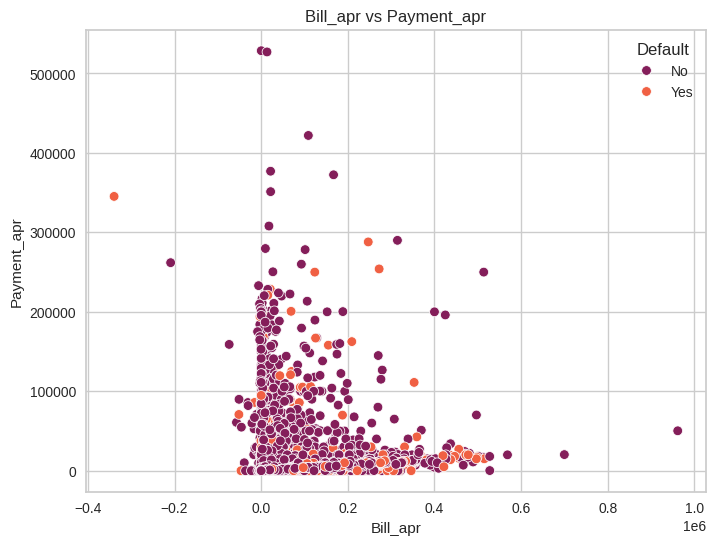

In [33]:
#Scatterplots of bill vs payment amounts
bill_cols = ['bill_sept', 'bill_aug', 'bill_jul', 'bill_jun', 'bill_may', 'bill_apr']
payment_cols = ['payment_sept', 'payment_aug', 'payment_jul', 'payment_jun', 'payment_may', 'payment_apr']

for bill_col, payment_col in zip(bill_cols, payment_cols):
  plt.figure(figsize=(8, 6))
  sns.scatterplot(x=bill_col, y=payment_col, data=df_train_copy, hue='default', palette='rocket')
  plt.title(f'{bill_col.capitalize()} vs {payment_col.capitalize()}')
  plt.xlabel(bill_col.capitalize())
  plt.ylabel(payment_col.capitalize())
  plt.legend(title='Default')
  plt.show()

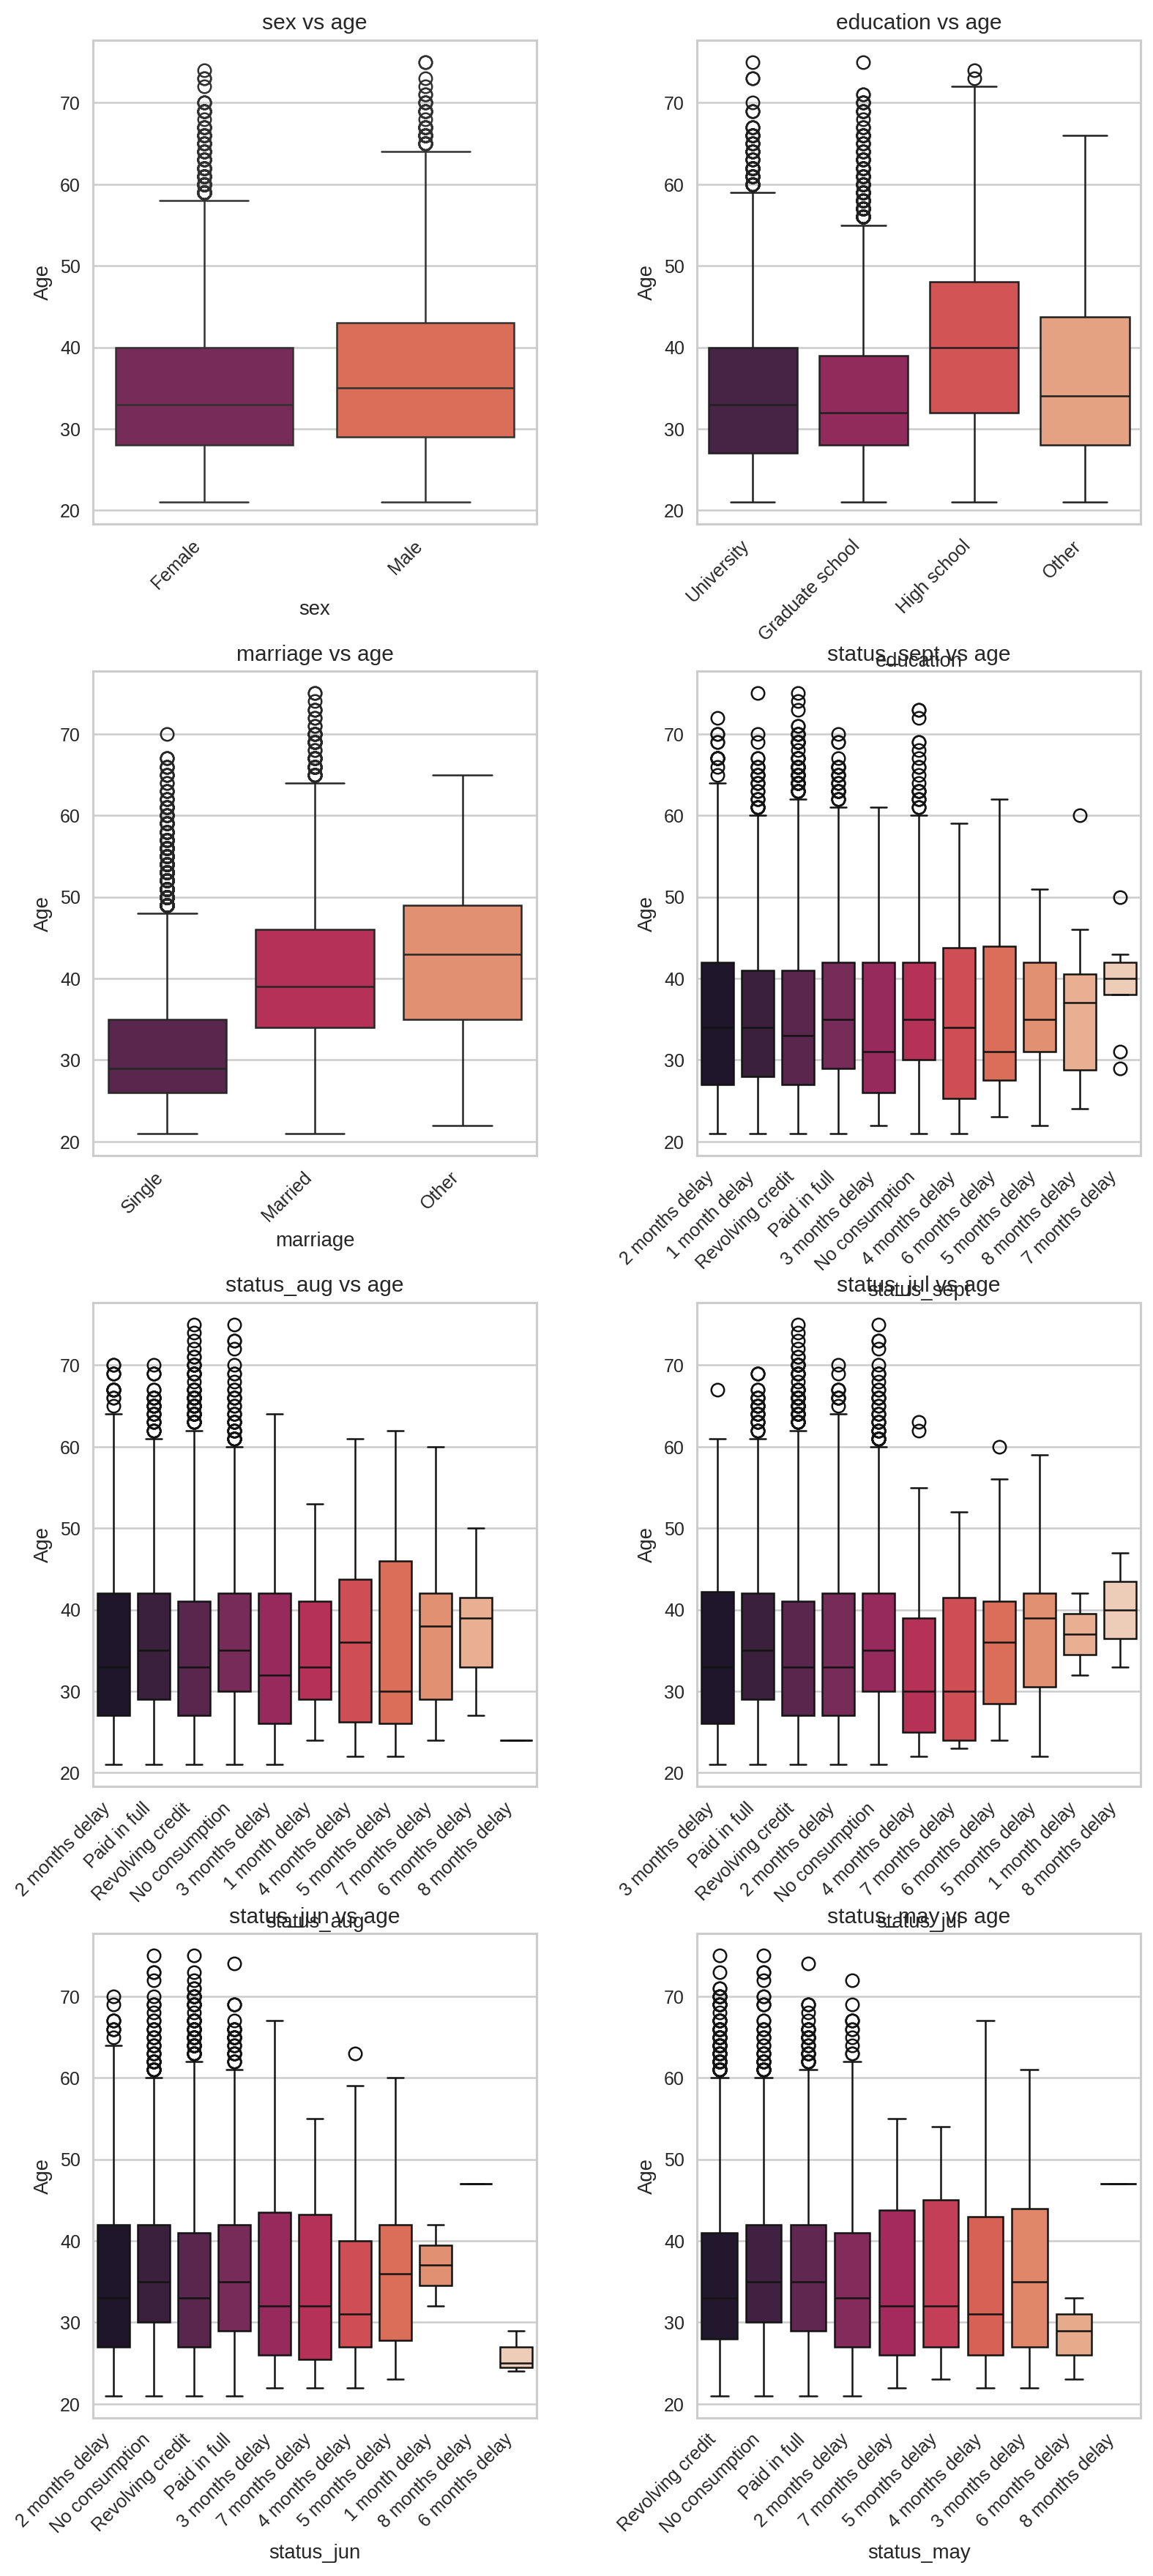

In [34]:
#2. Numerical - categorical features

#Boxplots of age vs categorical features
fig, axes = plt.subplots(4,2,figsize=(10,20),dpi=180)
fig.tight_layout(pad=5.0)
cat_features = ['sex', 'education', 'marriage', 'status_sept','status_aug', 'status_jul', 'status_jun', 'status_may', 'status_apr', 'default']
for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=df_train_copy[cat_features[cat_ft_count]],y=df_train_copy['age'], palette='rocket')
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs age")
            plt.sca(axes[row_count,feat_count])
            plt.xticks(rotation=45,ha='right')
            plt.ylabel('Age')
            cat_ft_count += 1
    break

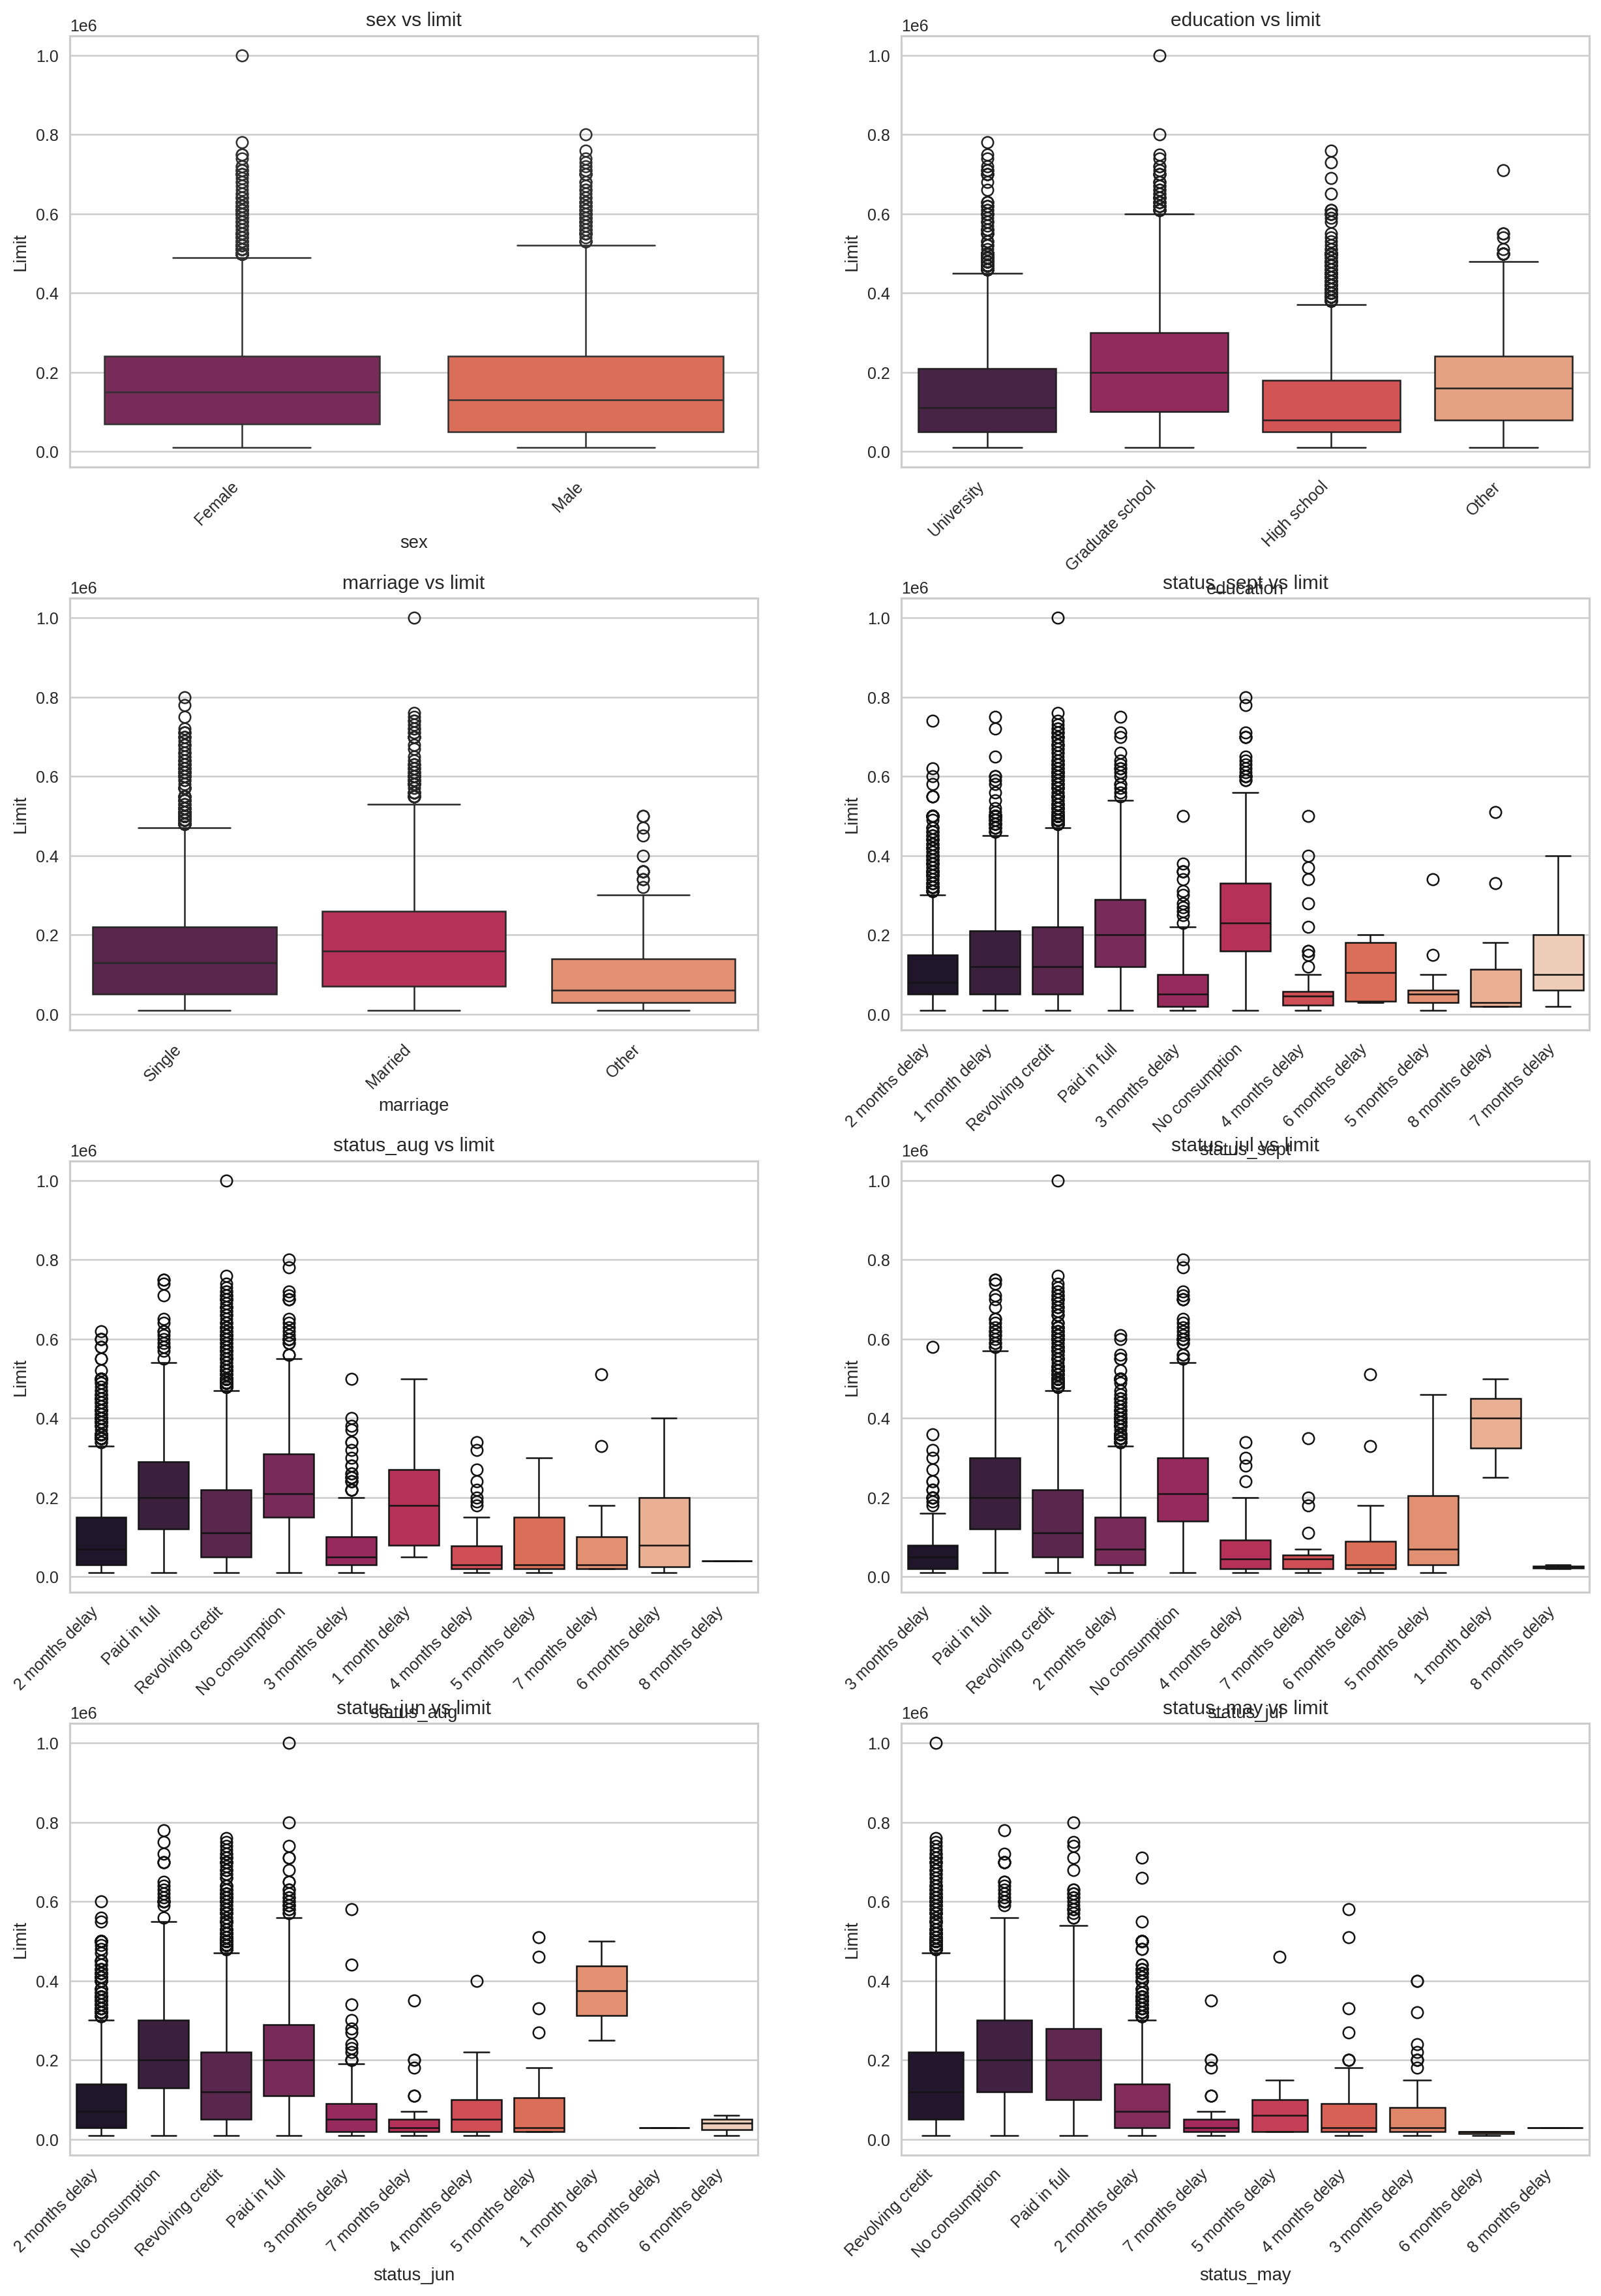

In [35]:
#Limit vs categorical features
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)
cat_features = ['sex', 'education', 'marriage', 'status_sept','status_aug', 'status_jul', 'status_jun', 'status_may', 'status_apr', 'default']
for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=df_train_copy[cat_features[cat_ft_count]],y=df_train_copy['limit'], palette='rocket')
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs limit")
            plt.sca(axes[row_count,feat_count])
            plt.xticks(rotation=45,ha='right')
            plt.ylabel('Limit')
            cat_ft_count += 1
    break

In [36]:
#Function ploting the distribution of categorical features against the 'default' status
def plot_categorical_against_default(dataframe, cat_features):
    num_plots = len(cat_features)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    fig.tight_layout(pad=3.0)
    for i, feature in enumerate(cat_features):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]
        sns.countplot(x=feature, hue='default', data=dataframe, palette='rocket', ax=ax)
        ax.set_title(f'{feature.capitalize()} by Default Status')
        ax.set_xlabel(feature.capitalize())
        ax.set_ylabel('Count')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        ax.legend(title='Default')
    if num_plots < num_rows * num_cols:
        for i in range(num_plots, num_rows * num_cols):
            row = i // num_cols
            col = i % num_cols
            ax = axes[row, col] if num_rows > 1 else axes[col]
            ax.axis('off')

    plt.show()

To sum up the exploratory data analysis, a typical characteristic profile of an individual who is expected to default can be drafted:
- Male, with lower education (high school or less),
- In the older age group (over 45),
- Married or with significant family responsibilities,
- And having a lower credit limit, potentially due to perceived higher risk or lower
income.

## Data pre-processing
Referring to the transformations that need to be applied to the training data before feeding it into the ML model, data pre-processing is crucial to improve data quality, enhance model performance, and avoid any bias (Layton, 2015).

Aiding with dimensionality reduction, feature selection was applied to transform existing data as ‘id’ column was found to be redundant for the predictive purposes of the model.

Following, a function to remove outliers was defined and applied to the training copy of the dataset, as outliers can make it ‘harder for the system to detect the underlying
patterns’ (Géron, 2019), particularly when using parametric techniques that assume a normal distribution, making the model overfit and perform worse. Outliers were defined by the ‘1.5xIQR’ rule – if the distance between above the 3rd quartile and below the 1st quartile is more than 1.5 times the interquartile range, the value can be considered an outlier and removed from the dataset (Walker, 2020). Following the removal of outliers and the ‘id’ row, the training dataset’s shape went down to 18623 values and 24 features.



In [39]:
#Feature selection: drop ID column or those that would not inform us with anything/highly correlated/missing values/features used to create the TV as can cause to overfit
df_train_copy = df_train_copy.drop('id', axis=1)
df_test_copy = df_test_copy.drop('id', axis=1)

In [40]:
#Data cleaning: outliers handling
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_outliers = ['limit', 'age', 'bill_sept', 'bill_aug', 'bill_jul', 'bill_jun', 'bill_may', 'bill_apr', 'payment_sept', 'payment_aug', 'payment_jul', 'payment_jun', 'payment_may', 'payment_apr']):
        self.feat_with_outliers = feat_with_outliers
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_outliers).issubset(df.columns)):
            Q1 = df[self.feat_with_outliers].quantile(.25)
            Q3 = df[self.feat_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            df = df[~((df[self.feat_with_outliers] < (Q1 - 3 * IQR)) |(df[self.feat_with_outliers] > (Q3 + 3 * IQR))).any(axis=1)]
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

In [41]:
df_train_copy = OutlierRemover().fit_transform(df_train_copy)
df_test_copy = OutlierRemover().fit_transform(df_test_copy)

In [42]:
df_train_copy.shape

(18623, 24)

As despite the outlier removal, the distributions of numeric variables were still positively skewed, a log transformation was applied. While it would not be necessary for tree-based models; linear algorithms and neural networks are tied to the scale and distribution of each feature. Log transformation aids not just by normalising the distribution, but also by adjusting the relative scales in the data so that they can be captured better by the linear models or neural networks.

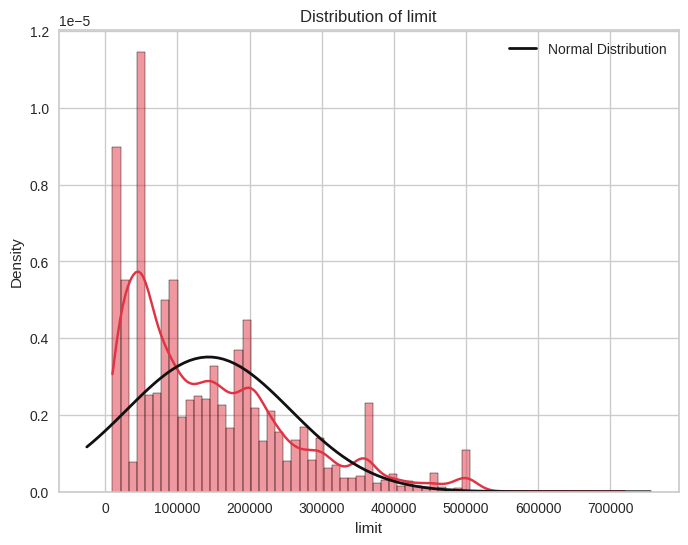

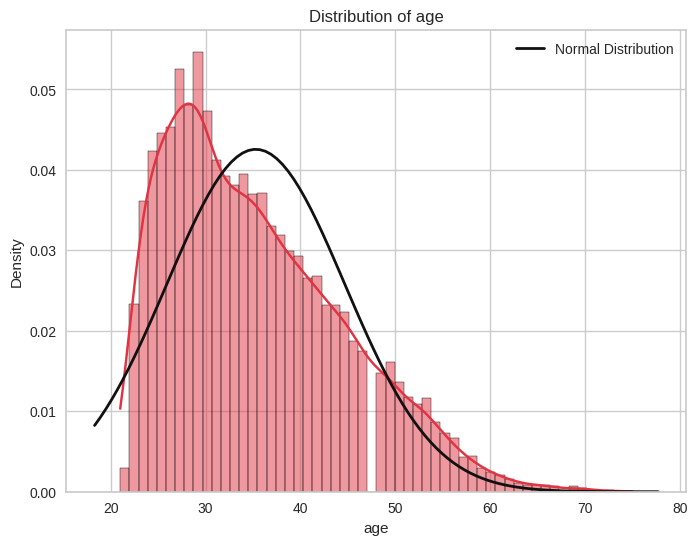

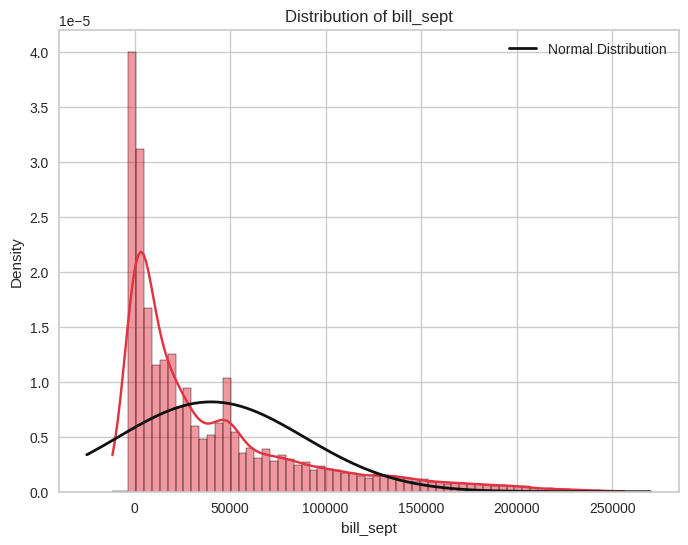

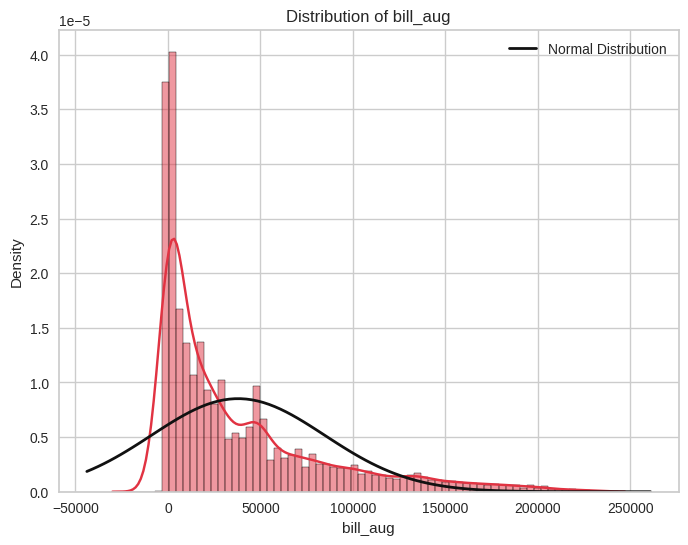

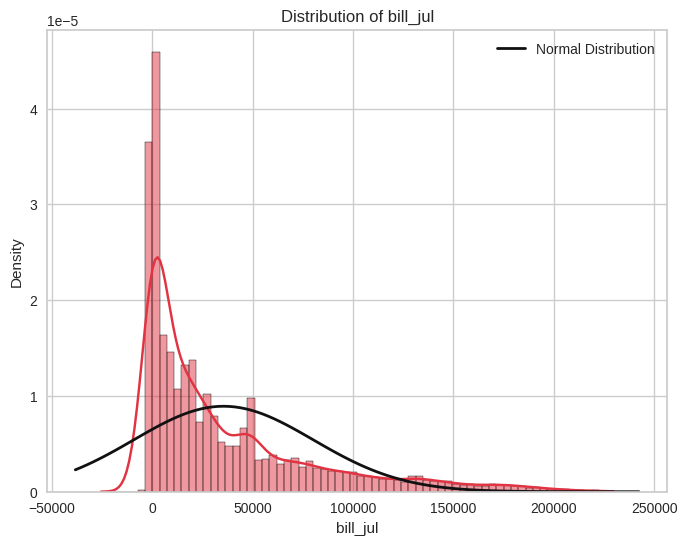

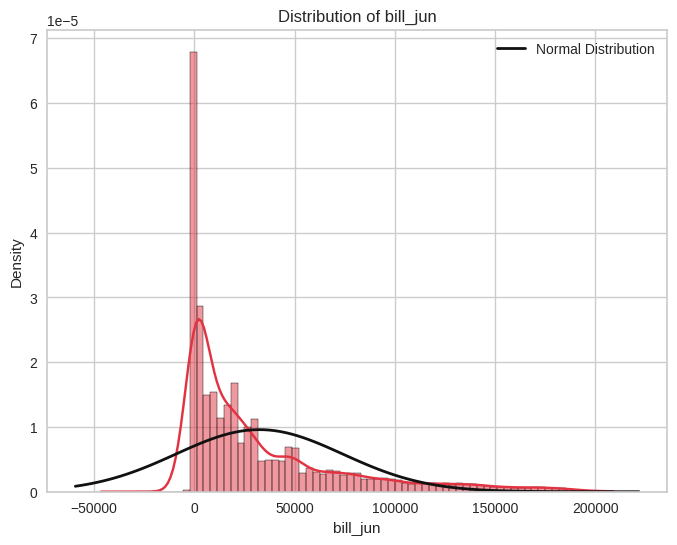

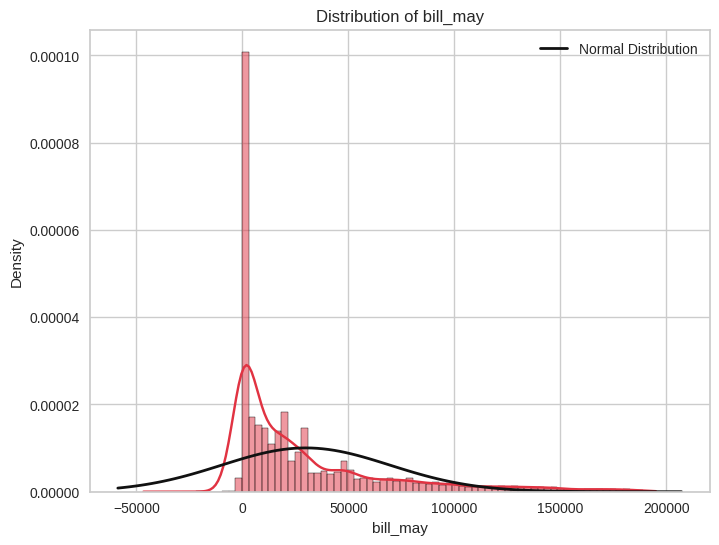

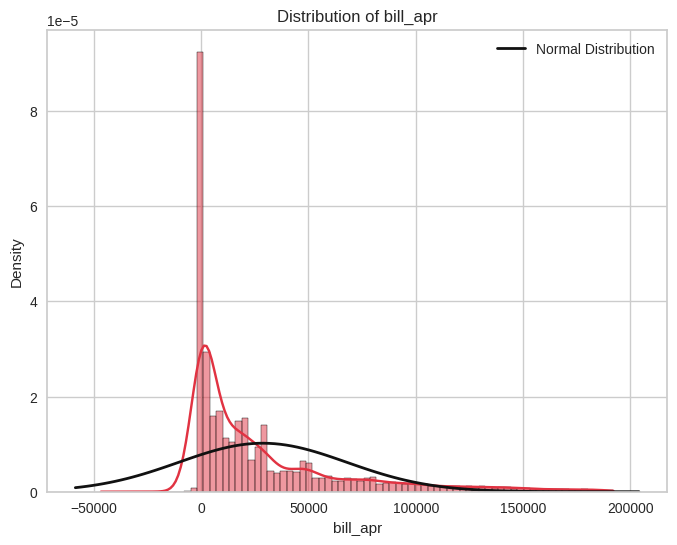

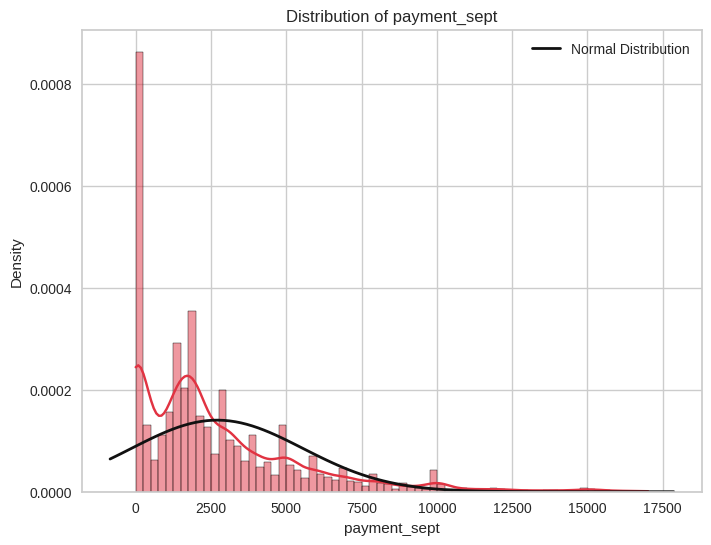

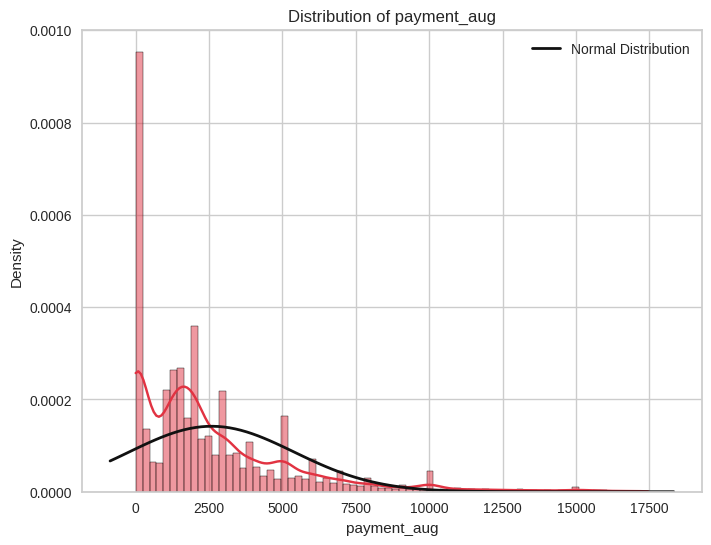

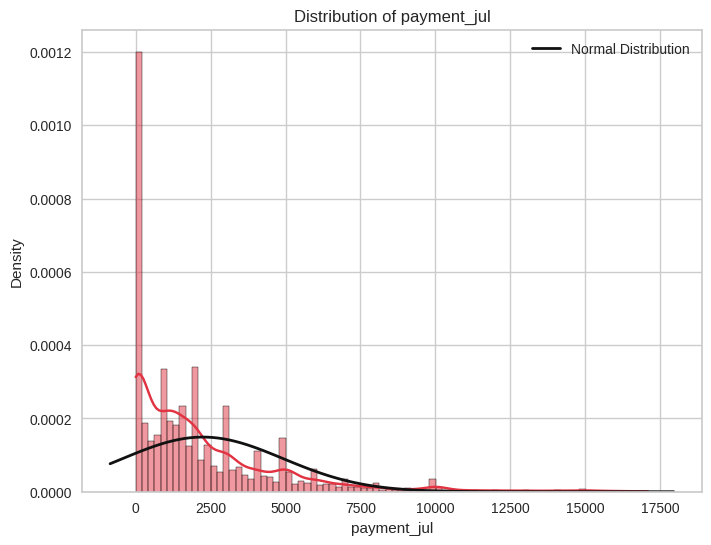

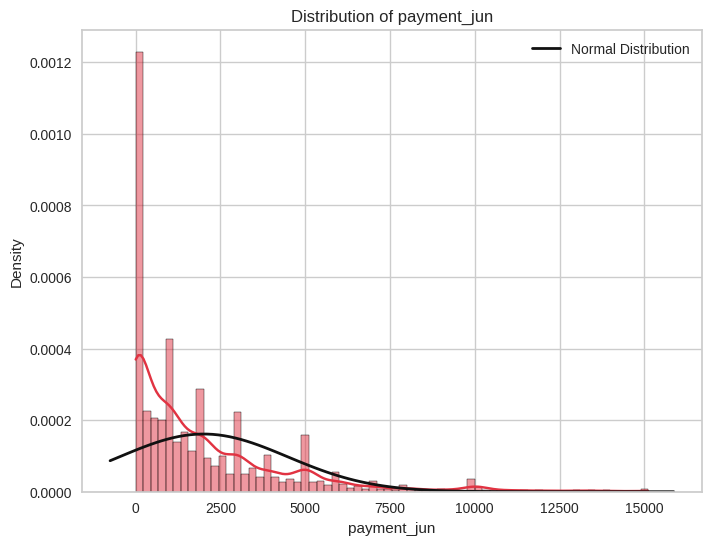

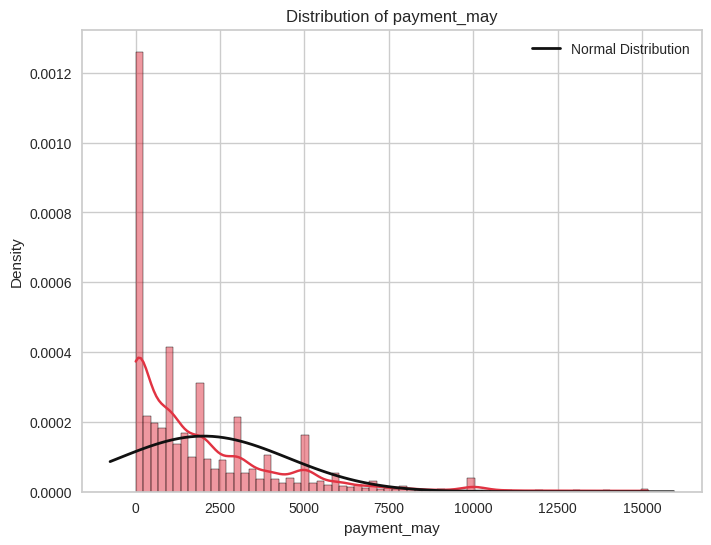

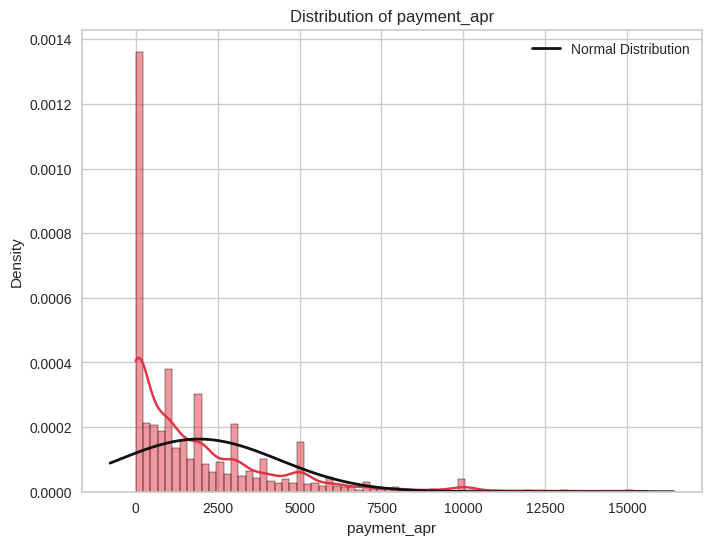

In [43]:
def explore_numeric_distributions(df):
    numeric_cols = df.select_dtypes(include=['number']).columns

    for col in numeric_cols:
        plt.figure(figsize=(8, 6))
        sns.histplot(df[col], kde=True, color=sns.color_palette("rocket")[3], stat="density")
        mu, std = norm.fit(df[col])
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.legend()
        plt.show()

explore_numeric_distributions(df_train_copy)

In [44]:
#Log transformation as right-skewed distributions
numeric_cols = df_train_copy.select_dtypes(include=['number']).columns
for col in numeric_cols:
    df_train_copy[col] = np.where(df_train_copy[col] <= 0, 1e-6, df_train_copy[col])

df_train_copy.loc[:, numeric_cols] = np.log(df_train_copy[numeric_cols])

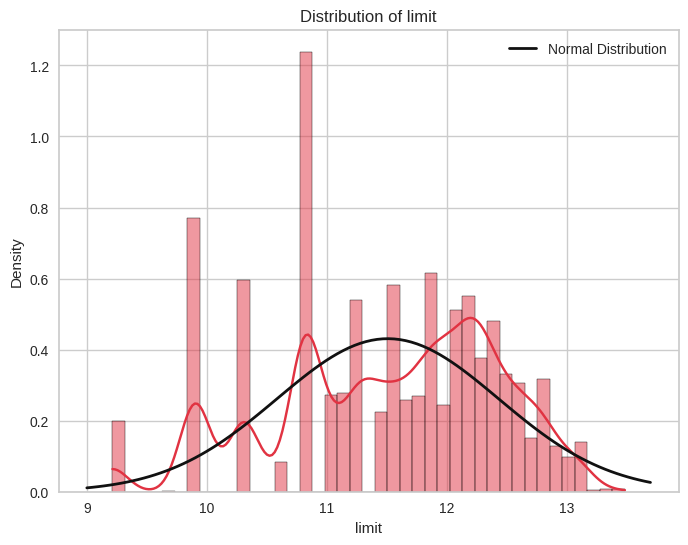

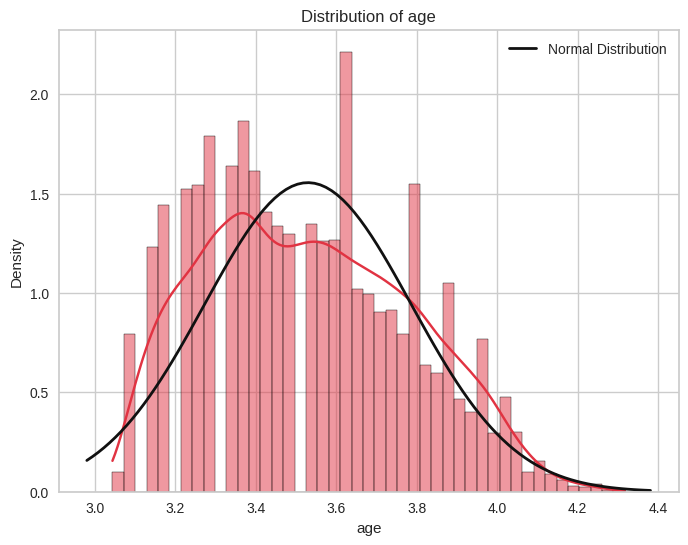

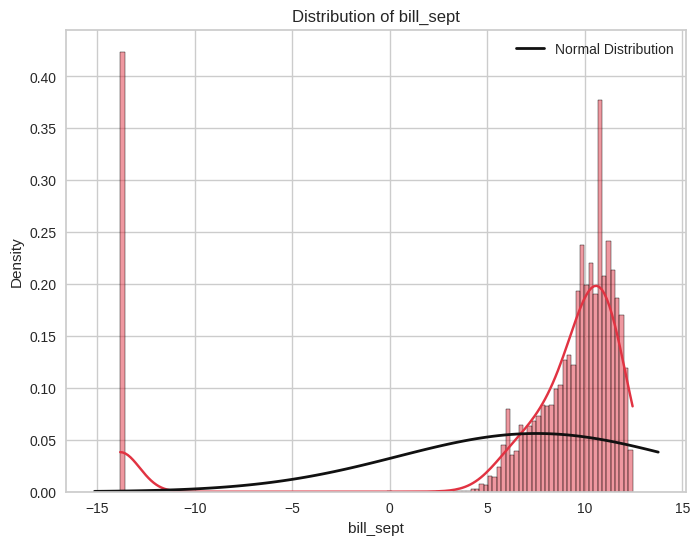

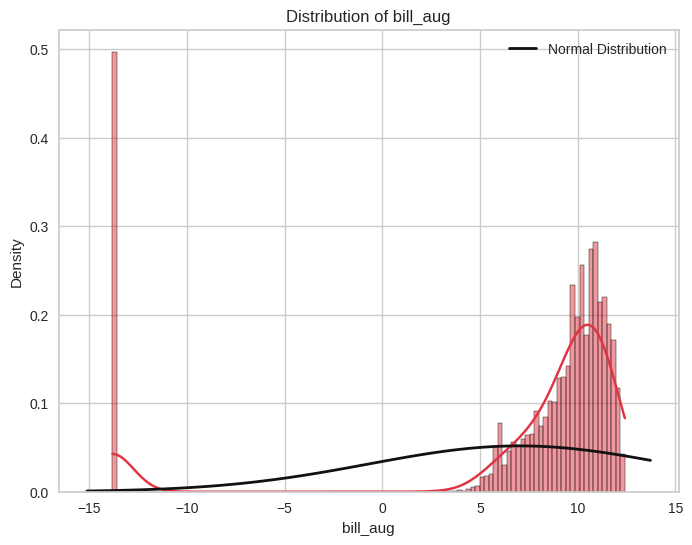

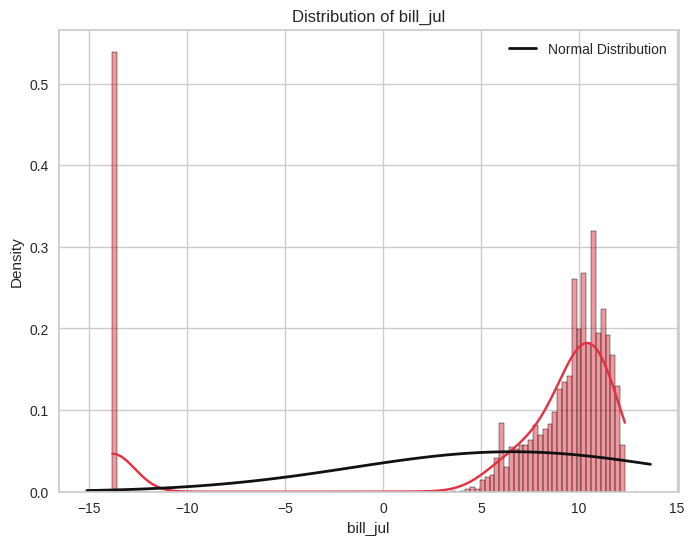

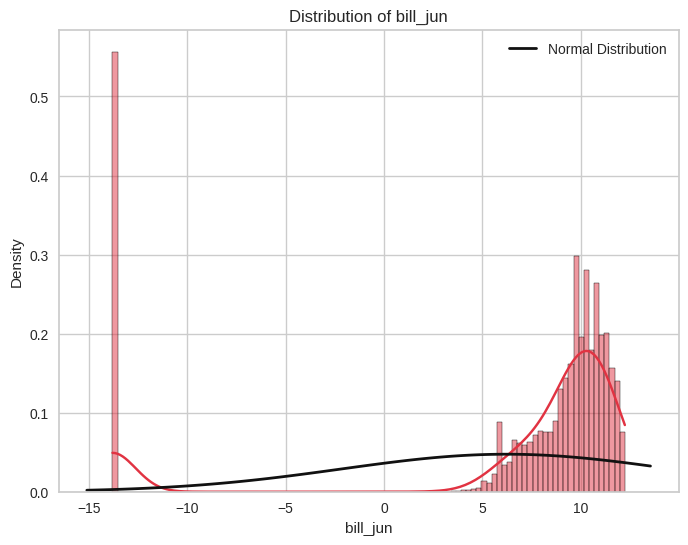

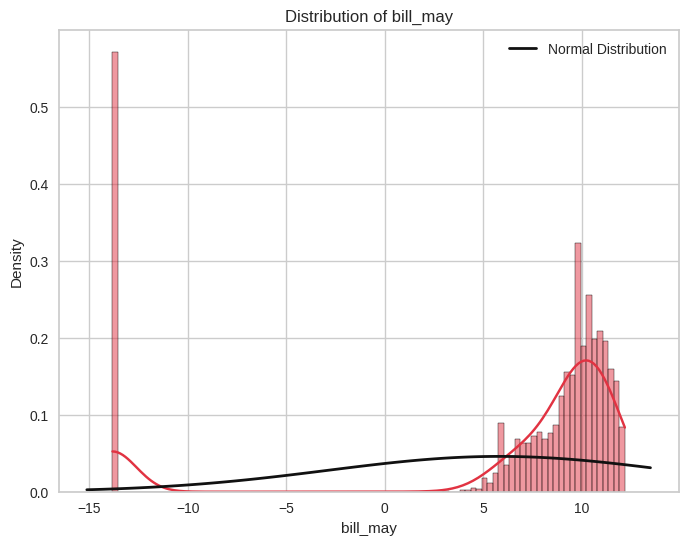

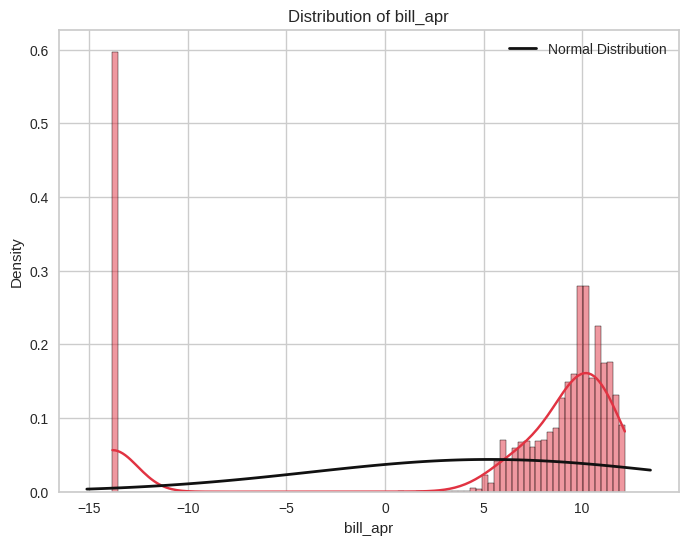

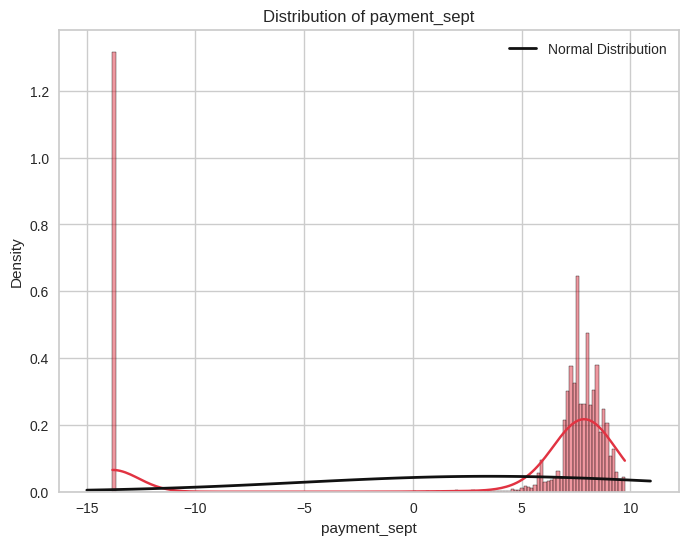

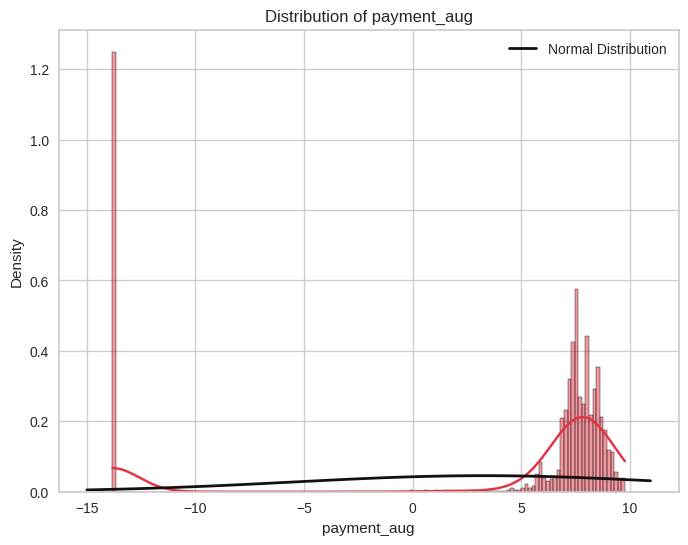

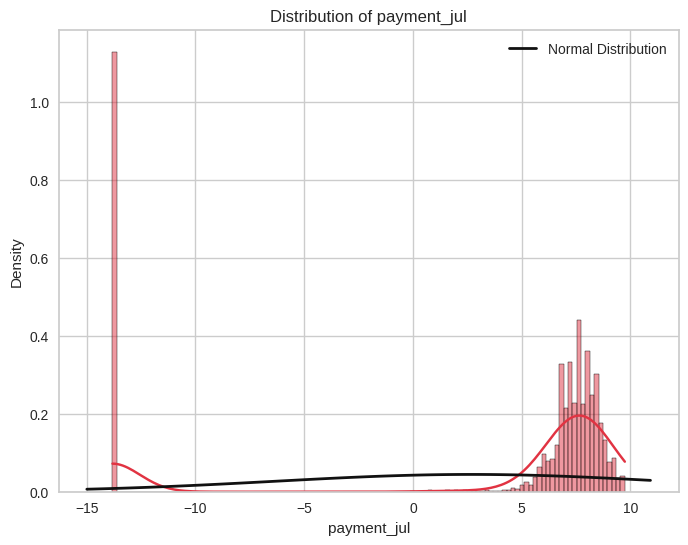

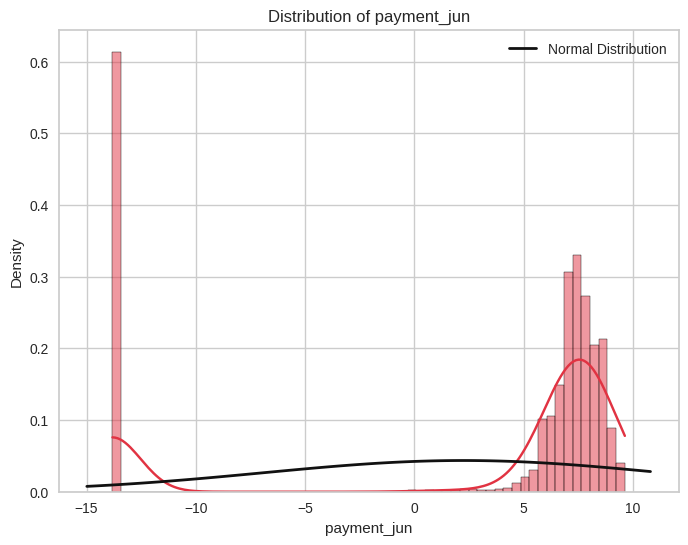

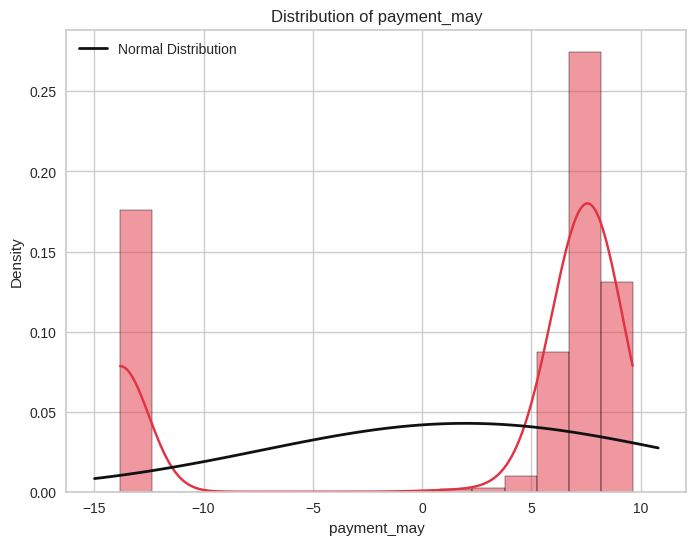

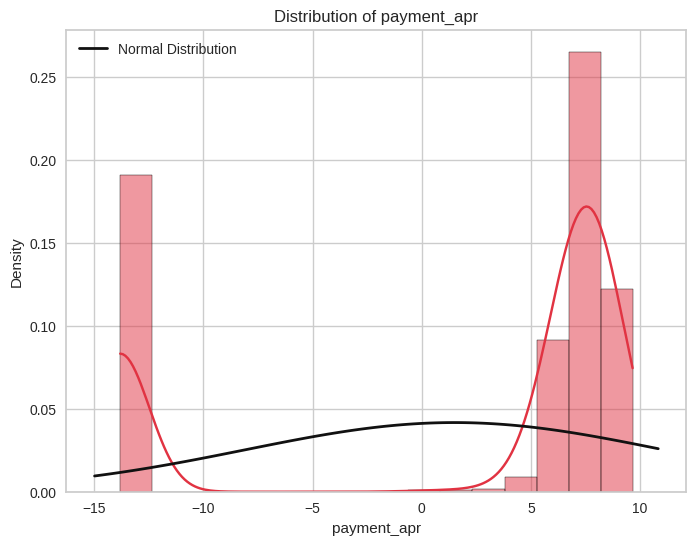

In [45]:
explore_numeric_distributions(df_train_copy)

As machine learning algorithms rely on numerical features to learn, all categorical variables have been encoded into one-hot encoded vectors to guarantee reliable results (Layton, 2015).

In [46]:
#Feature engineering (imputers unneccessary)
num_pipeline = Pipeline([('num_imputer',SimpleImputer(strategy="median")),
                        ('std_scalar',StandardScaler())])

cat_pipeline = Pipeline([('cat_imputer', SimpleImputer(strategy="constant", fill_value='None')),
                         ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])

In [47]:
#Only scale the independent variables, not the TV!
default_column = df_train_copy['default']
df_without_default = df_train_copy.drop(columns=['default'])


num = df_without_default.select_dtypes(['int64', 'float64'])
cat = df_without_default.select_dtypes(['object'])

full_pipeline=ColumnTransformer([("num", num_pipeline, list(num)),
                                 ("cat", cat_pipeline, list(cat))],
                                 remainder='passthrough',
                                 verbose_feature_names_out=False)

In [48]:
full_pipeline.set_output(transform='pandas')
df_train_prepared = full_pipeline.fit_transform(df_without_default)
df_train_prepared['default'] = default_column
df_train_prepared.head()
df_train_prepared.isnull().sum()
df_train_prepared.shape

(18623, 87)

In [49]:
full_pipeline.set_output(transform='pandas')
df_without_default = df_test_copy.drop(columns=['default'])
df_test_prepared = full_pipeline.transform(df_without_default)
df_test_prepared['default'] = df_test_copy['default']
df_test_prepared.shape

(4666, 87)

In [50]:
df_train_prepared.head()

limit       age  bill_sept  bill_aug  bill_jul  bill_jun  bill_may  \
22788  0.512349 -0.130794   0.628612  0.654477  0.669798  0.686744  0.710208   
29006  0.442655 -0.014446  -3.000345 -0.395900 -2.503467 -2.385309 -2.256666   
16950 -2.481748  1.488616   0.239606  0.258000  0.302333  0.328213  0.367220   
11346  1.226588 -0.250722  -3.000345 -2.705537 -0.097178 -0.053476 -2.256666   
4102   0.950208  0.208320   0.149721  0.237485  0.272967  0.274804  0.426249   

       bill_apr  payment_sept  payment_aug  ...  status_apr_3 months delay  \
22788  0.735263      0.707968    -1.952150  ...                        0.0   
29006 -2.099449      0.054458    -1.952150  ...                        0.0   
16950  0.409646     -0.324896     0.443050  ...                        0.0   
11346 -2.099449     -2.004380     0.286746  ...                        0.0   
4102   0.368543      0.619065    -0.064906  ...                        0.0   

       status_apr_4 months delay  status_apr_5 months delay  \
22788                        0.0                        0.0   
29006                        0.0                        0.0   
16950                        0.0                        0.0   
11346                        0.0                        0.0   
4102                         0.0                        0.0   

       status_apr_6 months delay  status_apr_7 months delay  \
22788                        0.0                        0.0   
29006                        0.0                        0.0   
16950                        0.0                        0.0   
11346                        0.0                        0.0   
4102                         0.0                        0.0   

       status_apr_8 months delay  status_apr_No consumption  \
22788                        0.0                        0.0   
29006                        0.0                        1.0   
16950                        0.0                        0.0   
11346                        0.0                        1.0   
4102                         0.0                        0.0   

       status_apr_Paid in full  status_apr_Revolving credit  default  
22788                      0.0                          1.0       No  
29006                      0.0                          0.0       No  
16950                      0.0                          1.0       No  
11346                      0.0                          0.0       No  
4102                       0.0                          0.0      Yes  

[5 rows x 87 columns]

In [51]:
#Dividing the variables into independent and target
X_train=df_train_prepared.drop('default', axis=1)
y_train=df_train_prepared['default']
X_test=df_test_prepared.drop('default', axis=1)
y_test=df_test_prepared['default']

Following, with the assistance of Mutual Information (MI) metric, the process of feature selection took place. Measuring the dependency between the variables, MI is a non-negative value that helps prioritise features with the highest predictive power and is particularly useful in high-dimensional data settings where we might want to reduce the dimensionality of the dataset. The higher the value, the higher the dependency. According to the visualisation of the results, payment delay, revolving credit status, payment history, bill amounts are the features have the strongest power when it comes to predicting the default status. Only the features with MI value over 0.01 were selected to be included in the process of modelling, significantly reducing the dimensionality of dataset, as the number of features went down to 18.

In [52]:
#As df high-dimensional, it could benefit from dimensionality reduction
importances = mutual_info_classif(X=X_train, y=y_train, random_state=42)
feat_importances = pd.Series(importances,df_train_prepared.columns[0:len(df_train_prepared.columns)-1])

In [53]:
importances = pd.Series(importances)
importances.index = X_train.columns
sorted = importances.sort_values(ascending=False)
print(sorted.nlargest(20))

status_sept_2 months delay      0.053358
status_aug_2 months delay       0.047178
status_jul_2 months delay       0.035697
status_sept_Revolving credit    0.034769
status_jun_2 months delay       0.024721
status_may_2 months delay       0.022511
payment_sept                    0.021660
status_apr_2 months delay       0.021357
status_aug_Revolving credit     0.021307
payment_aug                     0.017966
limit                           0.017147
payment_jun                     0.016996
payment_jul                     0.014863
status_jul_Revolving credit     0.012413
payment_may                     0.011349
bill_sept                       0.011243
status_jun_Revolving credit     0.010830
bill_may                        0.010791
payment_apr                     0.010625
bill_jul                        0.010391
dtype: float64


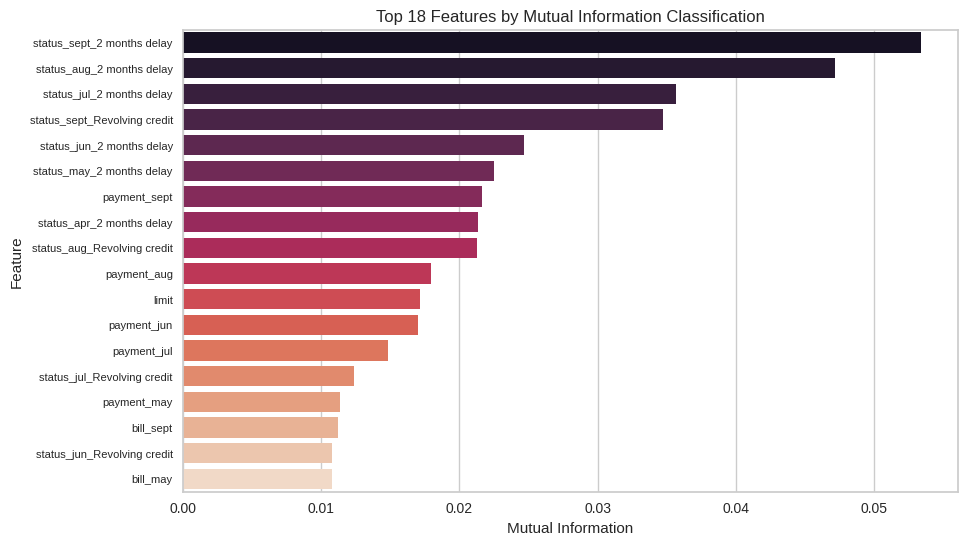

In [54]:
#Visualising top 20 features with most MI
N = 18
top_features = sorted.nlargest(N)

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=top_features.values, y=top_features.index, legend=False, palette='rocket')
barplot.tick_params(axis='y', labelsize=8)
plt.title(f'Top {N} Features by Mutual Information Classification')
plt.xlabel('Mutual Information')
plt.ylabel('Feature')
plt.show()

Feature 0: 0.017279
Feature 1: 0.000000
Feature 2: 0.010936
Feature 3: 0.004158
Feature 4: 0.013493
Feature 5: 0.009216
Feature 6: 0.011826
Feature 7: 0.005813
Feature 8: 0.020861
Feature 9: 0.011379
Feature 10: 0.014844
Feature 11: 0.017266
Feature 12: 0.007410
Feature 13: 0.009839
Feature 14: 0.004576
Feature 15: 0.000787
Feature 16: 0.007034
Feature 17: 0.003333
Feature 18: 0.000000
Feature 19: 0.005258
Feature 20: 0.005650
Feature 21: 0.000000
Feature 22: 0.000414
Feature 23: 0.006742
Feature 24: 0.052320
Feature 25: 0.003626
Feature 26: 0.001687
Feature 27: 0.000000
Feature 28: 0.000000
Feature 29: 0.003752
Feature 30: 0.000000
Feature 31: 0.000000
Feature 32: 0.000371
Feature 33: 0.036315
Feature 34: 0.000000
Feature 35: 0.042798
Feature 36: 0.003106
Feature 37: 0.004082
Feature 38: 0.000629
Feature 39: 0.000000
Feature 40: 0.000014
Feature 41: 0.000000
Feature 42: 0.000509
Feature 43: 0.000010
Feature 44: 0.021173
Feature 45: 0.000000
Feature 46: 0.026463
Feature 47: 0.004592
Fe

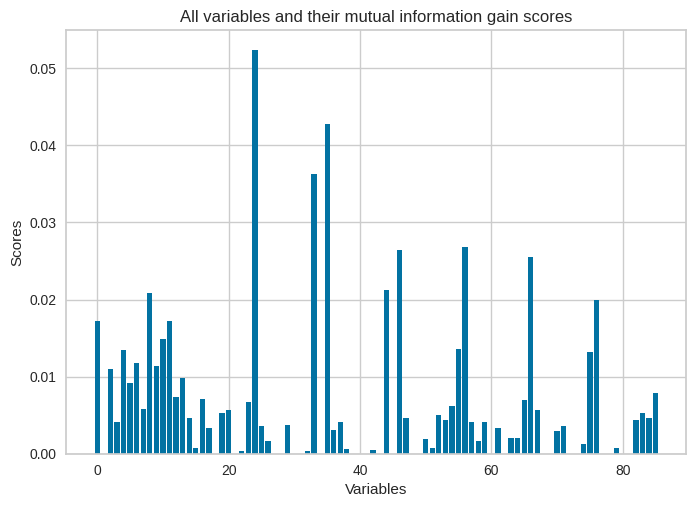

In [55]:
#SelectKBest calculates the MI scores (same as before) and ranks the features based on these scores and ACTUALLY selects the top k features and transforms your data to include only those selected features.
np.random.seed(420)

fs = SelectKBest(mutual_info_classif, k='all')
fs.fit(X_train, y_train)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)
for i in range(len(fs.scores_)):
 print('Feature %d: %f' % (i, fs.scores_[i]))

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.title(f'All variables and their mutual information gain scores')
plt.xlabel('Variables')
plt.ylabel('Scores')
plt.show()

In [56]:
count_over_001 = sum(score > 0.01 for score in fs.scores_)
print("Number of features with scores over 0.01:", count_over_001)

Number of features with scores over 0.01: 18


In [57]:
feature_names = df_train_prepared.drop('default', axis=1).columns
selected_features = [feature_names[i] for i, score in enumerate(fs.scores_) if score > 0.01]
print("Selected features with scores over 0.01:", selected_features)

Selected features with scores over 0.01: ['limit', 'bill_sept', 'bill_jul', 'bill_may', 'payment_sept', 'payment_aug', 'payment_jul', 'payment_jun', 'status_sept_2 months delay', 'status_sept_Revolving credit', 'status_aug_2 months delay', 'status_aug_Revolving credit', 'status_jul_2 months delay', 'status_jul_Revolving credit', 'status_jun_2 months delay', 'status_may_2 months delay', 'status_may_Revolving credit', 'status_apr_2 months delay']


In [58]:
#Best 18 features
def select_features(X_train, y_train, X_test):
 fs = SelectKBest(score_func=mutual_info_classif, k=18)
 fs.fit(X_train, y_train)
 X_train_fs = fs.transform(X_train)
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs

X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

print(f"X_train_fs shape: {X_train_fs.shape}")
print(f"X_test_fs shape: {X_test_fs.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train_fs shape: (18623, 18)
X_test_fs shape: (4666, 18)
X_train shape: (18623, 86)
X_test shape: (4666, 86)
y_train shape: (18623,)
y_test shape: (4666,)


In [59]:
print(X_train_fs[0])

[ 0.51234934  0.62861161  0.70796823 -1.95214976 -1.83332027  0.70757565
  0.75352054  1.          0.          1.          0.          0.
  0.          1.          0.          0.          1.          0.        ]


## Methodology
Being an ‘ideal technological framework for the financial industry’ (Hilpisch, 2019), Python was used to conduct the credit risk modelling project, as it is characterised by a number of benefits, like an elegant syntax, efficient development approaches, and usability for prototyping as well as production (Hilpisch, 2019). As the goal of the model is to predict whether the card member would default or not, it makes it a binary classification problem working to predict a class label based on different input features. To find the most accurate ML model for the predictive task, the following methods were used:

### Stochastic Gradient Descent (SGD)

As a variant of Gradient Descent that is used to optimise ML classification models, when dealing with large datasets SGD addresses the computational inefficiencies of the Gradient Descent (Duchesnay et al., 2021; Géron, 2019). The method works by picking a random instance in the training set at every step and computing the gradients based only on the single instance making the algorithm much faster since it has very little data to manipulate at each iteration. Its performance makes it appropriate to train on huge training sets, since only one
instance needs to be in memory at each iteration. Due to its stochastic nature, however, it is less regular and noisier than Batch Gradient Descent, making the cost function bounce up and down, never settle down, instead of gently decreasing it until it reaches the minimum. That makes the final parameter values good, but not optimal and could potentially be solved by gradually reducing the learning rate. As SGD assumes that training instances are independent and identically distributed (IID) to ensure that the parameters get pulled towards the global optimum, on average, it is crucial to shuffle the instances during training, so they are not sorted by label.

### Logistic Regression

Being the most common special instance of generalised linear models (GLMs) (Bruce et al. 2020), logistic regression is commonly used to establish the probability that an instance belongs to a particular class. Like the linear regression model, it computes a weighted sum of the input features (plus a bias term), but instead of outputting the result directly like the former, it outputs the logistic of the result – a sigmoid function outputting a number between 0 and 1. If the estimated probability is greater than 50%, the model predicts that the instance belongs to the positive class (labelled ‘1’), or else it predicts that it does not (the negative class, labelled ‘0’) (Géron, 2019). Despite being characterised by fast computational speed and its output of a model that lends itself to rapid scoring of new data, making it reproducible and relatively easy to interpret compared to other classification models; logistic regression might struggle with generalisation performance in lower-dimensional spaces (Muller and Guido, 2017). Logistic regression assumes the normal distribution of the input features, linear relationship between the former and the target variable, as well as no multicollinearity as it would inflate the variance of the estimated regression coefficients leading to unreliable predictions.

### Support Vector Machine (SVM)

Widely acknowledged and revered in the field of data mining and ML since its discovery by Vapnik in the 1990s, SVM is a linear classifier that also performs non-linear classification problems using the kernel function. In classification tasks, the algorithm works by building a margin hyperplane with maximum marginal distance between two classes to enforce robustness against the noise (Duchesnay et al., 2021; Sharma et al., 2020). The higher the distance, the more generalisable the result is. Support vector machine has been widely recognised for its ability to effectively handle complex data patterns and achieve high- dimensional classification tasks with remarkable accuracy (Sharma et al., 2024), however it is also characterised by sensitivity when it comes to feature scales (Géron, 2019). In contrary to logistic regression, SVMs are also not susceptible to collinear data and do not require the generation of interaction or higher order terms (Layton, 2015; Refaat, 2007). Just like neural network algorithms, SVM assumes that the training dataset contains only of numeric non- missing data.

### Random Forest

Random forest is a robust and versatile ensemble learning technique that combines multiple decision trees to make a prediction by applying the concept of the ‘wisdom of crowds’ (Bruce et al., 2020). By averaging the results of an ensemble of models via the bagging method, it is much more accurate and powerful than one decision tree model, resulting in good predictive results with little effort. By training multiple decision trees on random bootstrap samples from the training data, random forest introduces extra randomness when growing trees, resulting in greater tree diversity and mitigating overfitting which makes it a reliable and precise method (Géron, 2019; Sharma et al., 2024). Despite countless advantages of the algorithm, a notable drawback of random forest is that it can become slow and inefficient when dealing with large numbers of trees, making it less suitable for real-time predictions. The method’s predictions can also become somewhat noisy and overfit the training data based on unusual records in the data and number of trees – e.g. some borrowers with high creditworthiness still would end up with a prediction of default (Bruce et al., 2020; Muller and Guido, 2017). As random forests also don’t perform on high-dimensional data and assume no multicollinearity between input features, it is important to commit to the process of feature selection to reduce the dimensionality of the training dataset.

### K-Nearest Neighbours (KNN)

Referred to as ‘the simplest machine learning algorithm’ (Muller and Guido, 2017), KNN makes predictions for the new data points based on the closest k data points in the training dataset – its ‘nearest neighbours’. By counting how many neighbours belong to a classes 0 and 1, it assigns the class that is more frequent, the majority class among the k-nearest neighbours. Despite being intuitive, simple, fast and easy to understand (Layton, 2015), it is also characterised by being computationally expensive, with its results dependent on how the features are scaled and how big k is set – if k is too low, there is a risk of including the noise in the data (overfitting); if it is too high, we may oversmooth the data and miss out on KNN’s ability to capture the local structure in the data, one of the method’s main advantages (Bruce et al., 2020). It assumes that all input features are numeric and not sparse most of the time.

### Gradient Boosting

An ‘award winning’ (Muller and Guido, 2017) boosting algorithm that works by sequentially adding predictors to an ensemble, each one correcting its predecessor. Instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by previous predictor (Géron, 2019). By default, there is no randomisation in gradient boosted trees, instead strong pre-pruning is used (e.g. creating shallow trees, with maximum depth of 1 to 5, or lowering the learning rate) to avoid overfitting and make the models faster and smaller in terms of storage memory (Géron, 2019; Muller and Guido, 2017). Despite being often, the most powerful method that works well without scaling, gradient boosting does not work well on high-dimensional sparse data, and requires careful tuning of the parameters, as well as a long time to train. It is usually recommended to apply gradient boosting after random forest, as it helps with squeezing out the best accuracy and can be more time effective as well.

### Linear Discriminant Analysis (LDA)

Introduced by R.A. Fisher in 1936, discriminant analysis makes up for the earliest statistical type of classifier. Slightly different from the original method proposed by Fisher, LDA seeks to divide records into two groups by focusing on maximising the ‘between’ sum of squares (measuring the variation between the two groups) relative to the ‘within’ sum of squares (measuring the within-group variation) weighted by the covariance matrix. By maximising the between sum o squares and minimising the within sum of squares, this algorithm yields the greatest separation between two groups (Bruce et al., 2020; Géron, 2019). Despite LDA assuming that predictor features are normally distributed continuous variables, this method works well even for nonextreme departures from normality and for binary input features. Not used as often anymore due to emergence of other advanced algorithms, LDA still receives the recognition for being useful when reducing dimensionality before running other classification algorithms (Duchesnay et al., 2021).

### Bagging (Bootstrap Aggregating)

Introduced in the 1994 by Leo Breiman, bagging works by fitting several ‘almost independent’ (Duchesnay et al., 2021) models on training data sampled with replacement, and averaging their predictions in order to obtain a model with a lower variance. Within classification, based on the accuracy result from each model the models then vote for the best prediction of the class. Designed to improve the stability of even highly unstable ML classification algorithms with no assumptions met (Soloff et al., 2024), it is also characterised by reducing variance and overfitting, as well as the fact that it can be parallelised as different models are fitted independently of each other. Despite being accurate, bagging can be computationally expensive and introduce a loss of interpretability to the model, potentially making the resultant model experience bias.

### Multilayer Perceptron (MLP)

Having its origin in attempts to simulate the behaviour of brain cells back in the 1970s, MLP plays a crucial role as a fundamental block in artificial neural networks (ANNs) offering a powerful tool for solving logical propositions in various domains (Géron, 2019; Refaat, 2007; Sharma et al., 2024). Composed of an input layer (the features), an output layer (the labels), and a number of hidden layers (making it deep), when performing a binary classification task MLP needs a single output neuron using the logistic activation function – the output will be a number between 0 and 1, which can be interpreted as the estimated probability of the positive class (1) (Géron, 2019). Characterised by not being sensitive to outliers, as well as learning both linear and non-linear functions, MLPs are among the most powerful algorithms, as they usually outperform all other models due to their complex structure (Hilpisch, 2019; Refaat, 2007). Despite their great performance, the method is computationally demanding and lacks extensive diagnostic measures offered by other classification models. Lastly, the algorithm assumes all data to be numeric, with no missing values (Refaat, 2007).

### AdaBoost (Adaptive Boosting)

Formulated by Freund and Schapire in 1995, AdaBoost is a classification algorithm that combines multiple weak learner classifiers to increase the accuracy of the strong learner classifier. It works by updating the observation weights attached to each of the training dataset’s observations and training a new weak learner with a special focus given to the observations misclassified by the current ensemble model. Following, it adds the weak learner to the weighted sum according to an update coefficient that expresses the performance of this weak model: the better a weak learner performs, the more it contributes to the strong learner (Duchesnay, 2021). Despite being characterised by being relatively easy to implement and less prone to overfitting, AdaBoost can also be sensitive to noise as it focuses on misclassified data; and cannot be parallelised since each predictor can only be trained after the previous predictor has been trained and evaluated (Géron, 2019).

In [60]:
#Models training
classifiers = {
    'sgd':SGDClassifier(random_state=42),
    'logistic_regression':LogisticRegression(random_state=42,max_iter=1000),
    'support_vector_machine':SVC(random_state=42,probability=True),
    'random_forest':RandomForestClassifier(random_state=42),
    'k_nearest_neighbors':KNeighborsClassifier(),
    'gradient_boosting':GradientBoostingClassifier(random_state=42),
    'linear_discriminant_analysis':LinearDiscriminantAnalysis(),
    'bagging':BaggingClassifier(random_state=42),
    'neural_network':MLPClassifier(random_state=42,max_iter=1000),
    'adaboost':AdaBoostClassifier(random_state=42),
    }

In [61]:
#Model parameters
param_grids = {
    'sgd':
    {'loss': ['perceptron', 'hinge', 'log', 'modified_huber', 'squared_hinge'],
     'penalty': ['l1', 'l2', 'elasticnet'],
     'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
     'max_iter': [1000, 2000, 3000]
},
    'logistic_regression':
    {'penalty': ['l1', 'l2', 'elasticnet', None],
     'C': [0.01, 0.1, 1, 10, 100],
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'max_iter': [10, 100, 1000]
},
    'support_vector_machine':
    {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
     'C': [50, 10, 1.0, 0.1, 0.01],
     'gamma': ['scale', 'auto']
},
    'random_forest':
    {'n_estimators': range(100, 500, 100),
     'max_features': ['sqrt', 'log2', 'auto'],
     'max_depth': [7, 10, 15]
},
    'k_nearest_neighbors':
    {'n_neighbors': range(1, 21, 2),
     'weights': ['uniform', 'distance'],
     'metric': ['euclidean', 'manhattan', 'minkowski']
},
    'gradient_boosting':
    {'learning_rate': [0.01, 0.1, 1],
     'n_estimators': range(100, 500, 100),
     'max_depth': [3, 7, 9]
},
    'linear_discriminant_analysis':
    {'solver': ['svd', 'lsqr', 'eigen'],
     'shrinkage': [None, 'auto', 0.1, 0.5, 0.9, 1]
},
    'bagging':
    {'n_estimators': range(100, 1000, 100)
},
    'neural_network':
    {'solver': ['adam'],
     'max_iter': [100, 200, 300],
     'learning_rate': ['constant', 'invscaling', 'adaptive'],
     'hidden_layer_sizes': [(10,), (20,), (10, 10)],
     'batch_size': [200, 400, 600],
     'activation': ['tanh', 'relu', 'logistic']
},
    'adaboost':
    {'n_estimators': range(100, 1000, 100),
     'learning_rate': [0.001, 0.01, 0.1, 1]
}}

## Evaluation measures

As famously stated by the statistician George Box, ‘all models are wrong, but some of them are useful’ (quoted in Bolder, 2018), suggesting that no model will ever capture the complexity of the real world, however they can still help us to understand trends, make forecasts and guide the process of decision-making with a certain degree of accuracy in the predictions. In order to evaluate the performance of each model, a confusion matrix was applied as it is a ‘much better way to evaluate the performance of a classifier’ than a cross- validation (Géron, 2019). By comparing a set of predictions to the actual targets, confusion matrix provides the user with a detailed breakdown of model performance.

Based on confusion matrix, the following concise metrics were calculated to further review the algorithms’ performances:

- Precision - the accuracy of the positive predictions, usually used with a recall.
- Recall (Sensitivity/True Positive Rate) - ratio of positive instances that are correctly detected by the classifier; increasing recall reduces precision and vice versa (precision/recall trade- off).
- F1 Score – a harmonic mean of precision and recall, gives much more weight to the low values (meaning the classifier will only get a high score if both recall and precision are high).
- Receiver Operating Characteristic (ROC) Curve – common tool for binary classifiers that plots the recall against the false positive rate (ratio of negative instances that are incorrectly classified as positive) or specificity - one minus the true negative rate (ratio of negative instances that are correctly classified as negative).
- Area Under the Curve (AUC) – a metric used to evaluate a model’s ability to distinguish between positive and negative classes; a perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier a ROC AUC equal to 0.5.

In [62]:
#Feature importance
def feat_importance_plot(model_trn, model_name):
    if model_name not in ['sgd','support_vector_machine','gaussian_naive_bayes','k_nearest_neighbors','bagging','neural_network']:
        plt.rcParams['xtick.labelsize'] = 12
        plt.rcParams['ytick.labelsize'] = 12
        estimator = model_trn.best_estimator_
        top_10_feat = FeatureImportances(estimator, relative=False, topn=10)
        bottom_10_feat = FeatureImportances(estimator, relative=False, topn=-10)
        plt.figure(figsize=(10, 4))
        plt.xlabel('xlabel', fontsize=14)
        top_10_feat.fit(X_train, y_train)
        top_10_feat.show()
        print('\n')
        plt.figure(figsize=(10, 4))
        plt.xlabel('xlabel', fontsize=14)
        bottom_10_feat.fit(X_train, y_train)
        bottom_10_feat.show()
        print('\n')
    else:
        print('No feature importance for {0}'.format(model_name))
        print('\n')

In [63]:
#Function to get the y prediction
def y_prediction_func(model_trn,model_name,final_model=False):
    if final_model == False:
        y_train_pred_path = Path('saved_models/{0}/y_train_copy_pred_{0}.sav'.format(model_name))
        try:
            y_train_pred_path.resolve(strict=True)
        except FileNotFoundError:
            y_train_pred = cross_val_predict(model_trn,X_train,y_train,cv=10,n_jobs=-1)
            joblib.dump(y_train_pred,y_train_pred_path)
            return y_train_pred
        else:
            y_train_pred = joblib.load(y_train_pred_path)
            return y_train_pred
    else:
        y_train_pred_path_final = Path('saved_models_final/{0}/y_train_copy_pred_{0}_final.sav'.format(model_name))
        try:
            y_train_pred_path_final.resolve(strict=True)
        except FileNotFoundError:
            y_train_pred_final = cross_val_predict(model_trn,X_train,y_train,cv=10,n_jobs=-1)
            joblib.dump(y_train_pred_final,y_train_pred_path_final)
            return y_train_pred_final
        else:
            y_train_pred_final = joblib.load(y_train_pred_path_final)
            return y_train_pred_final

In [64]:
#Function to plot the confusion matrix
def confusion_matrix_func(model_trn,model_name,final_model=False):
    if final_model == False:
        fig, ax = plt.subplots(figsize=(8,8))
        conf_matrix = ConfusionMatrixDisplay.from_predictions(y_train,y_prediction_func(model_trn,model_name),ax=ax, cmap='Blues',values_format='d')
        plt.grid(visible=None)
        plt.xlabel('Predicted label', fontsize=14)
        plt.ylabel('True label', fontsize=14)
        plt.title('Confusion Matrix', fontsize=14)
        plt.show()
        print('\n')
    else:
        fig, ax = plt.subplots(figsize=(8,8))
        conf_matrix_final = ConfusionMatrixDisplay.from_predictions(y_train,y_prediction_func(model_trn,model_name,final_model=True),ax=ax, cmap='Blues',values_format='d')
        plt.grid(visible=None)
        plt.xlabel('Predicted label', fontsize=14)
        plt.ylabel('True label', fontsize=14)
        plt.title('Confusion Matrix', fontsize=14)
        plt.show()
        print('\n')

In [65]:
#Function to get the ROC + AUC
def roc_curve_func(model_trn, model_name, final_model=False):
    if final_model == False:
        y_proba_path = Path('saved_models/{0}/y_train_proba_{0}.sav'.format(model_name))
        try:
            y_proba_path.resolve(strict=True)
        except FileNotFoundError:
            y_train_proba = model_trn.predict_proba(X_train)
            joblib.dump(y_train_proba, y_proba_path)
        else:
            y_train_proba = joblib.load(y_proba_path)

        y_train_numeric = y_train.map({'No': 0, 'Yes': 1})
        fpr, tpr, thresholds = roc_curve(y_train_numeric, y_train_proba[:, 1])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc="lower right")
        plt.show()
        print('\n')

    else:
        y_proba_path_final = Path('saved_models_final/{0}/y_train_proba_{0}_final.sav'.format(model_name))
        try:
            y_proba_path_final.resolve(strict=True)
        except FileNotFoundError:
            y_train_proba_final = model_trn.predict_proba(X_train)
            joblib.dump(y_train_proba_final, y_proba_path_final)
        else:
            y_train_proba_final = joblib.load(y_proba_path_final)

        y_train_numeric = y_train.map({'No': 0, 'Yes': 1})
        fpr, tpr, thresholds = roc_curve(y_train_numeric, y_train_proba_final[:, 1])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc="lower right")
        plt.show()
        print('\n')

In [66]:
#Function to get the evaluation metrics
def score_func(model_trn, model_name, final_model=False):
    if final_model == False:
        y_train_pred = y_prediction_func(model_trn,model_name)
        class_report = classification_report(y_train,y_train_pred)
        print(class_report)
    else:
        y_train_pred = y_prediction_func(model_trn,model_name,final_model=True)
        class_report_final = classification_report(y_train,y_train_pred)
        print(class_report_final)
    y_train_pred_numeric = [1 if pred == 'Yes' else 0 for pred in y_train_pred]
    best_model = model_trn.best_estimator_
    y_train_proba = best_model.predict_proba(X_train)[:, 1]
    y_train_numeric = y_train.map({'No': 0, 'Yes': 1})
    auc_score = roc_auc_score(y_train_numeric, y_train_proba)
    print(f"AUC Score: {auc_score:.2f}")

In [67]:
#Function to train the model
def train_model(model,model_name,final_model=False):
    if final_model == False:
        model_file_path = Path('saved_models/{0}/{0}_model.sav'.format(model_name))
        try:
            model_file_path.resolve(strict=True)
        except FileNotFoundError:
            if model_name in param_grids:
                param_grid = param_grids[model_name]
                cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
                search = HalvingRandomSearchCV(model, param_grid, cv=cv)
                model_trn = search.fit(X_train, y_train)
                print("Best hyperparameters:", search.best_params_)
            else:
                model_trn = model.fit(X_train, y_train)
            return model_trn
        else:
            model_trn = joblib.load(model_file_path)
            return model_trn
    else:
        final_model_file_path = Path('saved_models_final/{0}/{0}_model.sav'.format(model_name))
        try:
            final_model_file_path.resolve(strict=True)
        except FileNotFoundError:
            model_trn = model.fit(X_train,y_train)
            joblib.dump(model_trn,final_model_file_path)
            return model_trn
        else:
            model_trn = joblib.load(final_model_file_path)
            return model_trn

In [68]:
def folder_check_model():
    if not os.path.exists('saved_models/{}'.format(model_name)):
        os.makedirs('saved_models/{}'.format(model_name))

In [69]:
warnings.filterwarnings("ignore")

# loop over all the models
for model_name,model in classifiers.items():
        # title formatting
        print('\n')
        print('\n')
        print('  {}  '.center(50,'-').format(model_name))
        print('\n')
        # check if the folder for saving the model exists, if not create it
        folder_check_model()
        # train the model
        model_trn = train_model(model,model_name)
        # print the scores from the classification report
        score_func(model_trn, model_name)
        # plot the ROC curve
        roc_curve_func(model_trn,model_name)
        # plot the confusion matrix
        confusion_matrix_func(model_trn,model_name)
        # plot feature importance
        feat_importance_plot(model_trn, model_name)





----------------------  sgd  ----------------------


Best hyperparameters: {'penalty': 'l1', 'max_iter': 2000, 'loss': 'hinge', 'alpha': 0.01}
              precision    recall  f1-score   support

          No       0.81      0.96      0.88     14055
         Yes       0.72      0.31      0.43      4568

    accuracy                           0.80     18623
   macro avg       0.76      0.64      0.66     18623
weighted avg       0.79      0.80      0.77     18623



AttributeError: This 'SGDClassifier' has no attribute 'predict_proba'

## Results

To make sure that the performance of models is as good as it can get, hyperparameter automatic search module – HalvingRandomSearchCV – was used to find the best values for each specific model. Applying a 5-fold cross-validation to evaluate the performance of each hyperparameter combination has resulted in best possible set up for each of the models. To compare the results between each individual model, weighted average was used for each metric, as it not only considers the number of samples in each class, aligning better with how model would perform on unseen data; but also gives a fairer representation of overall model performance for imbalanced datasets.

Based on the fact that ROC and AUC measure model’s ability to distinguish between those who would default and not across all classification thresholds, the results will be mainly based on those metrics. As the goal of the model is also to reduce loan defaults, avoid the false negatives (e.g. predicting as ‘low risk’ when the card member would actually be ‘high risk’), as well as capture most of the high-risk cases, recall will also be considered.

The random forest and neural network classifiers were found to be the best performing, offering relatively 96% and 81% accuracy and excellent discriminative abilities. With the recall score of 81%, both logistic regression and gradient boosting were found to be the best models for correctly identifying those who default, catching most risky borrowers, but misclassifying some low-risk individuals as high-risk, leading to unnecessary rejections. However, coupled with a 79% scores for precision for both of the algorithms, the models are well-balanced and not rejecting too many of the low-risk borrowers.

## Ethics
Ethical considerations are key in credit risk modelling to ensure fairness, transparency, and accountability, preventing unintentional discrimination and promoting responsible lending practices. Historical data that is used can often reflect societal biases, e.g. associating certain demographics with default, leading to unfair and discriminatory outcomes and potentially leading to perpetuating those inequalities. To mitigate the risk of bias, the dataset used has to be balanced, containing diverse representation of individuals; a process of feature engineering could assist with avoiding features that are likely to perpetuate bias.

## Conclusion

As errors made in risk management are ‘timeless’ (Bessis, 2015) leading to a potential financial loss from default, the process of risk management has been crucial in ensuring the wellbeing of both credit card companies and card holders. By leveraging exploratory data analysis, feature engineering, and model evaluation, the project has not only identified significant patterns between the individual’s characteristics and their default status but also developed accurate classification machine learning models. The results could potentially allow financial institutions make more objective, efficient, and accurate decisions regarding the customers’ assessment of creditworthiness, leading to profit maximisation, improved risk management, as well as ensuring ethical lending practices.